# Predicting Data Science Salaries

Hannah Minsuh Choi, Justin Liu, Shulei Wang

## Background

### Motivation

In the ever-evolving landscape of data science, understanding the factors influencing salaries is paramount for both workers and employers. For workers, this analysis could help them determine what a reasonable salary is for their desired role; for employers, knowing the key factors influencing salaries could allow them to develop competitive compensation strategies to attract and retain top talent.

This research project delves into the dynamic realm of data science salaries, with a specific focus on the period spanning from 2020 to 2023. The primary objective is to identify and analyze the key variables that play a crucial role in shaping compensation within the field of data science.

### Research Question

The central inquiry guiding this investigation is: **"What are the key variables that affect salaries in the Data Science field?"** Through an intricate examination of various parameters, we aim to unravel the intricate web of factors that contribute to the fluctuations and trends in data science salaries over the specified time frame.

### Dataset

The dataset for this research project is sourced from [ai-jobs.net](https://ai-jobs.net/), a site that aggregates data science jobs in areas such as artificial intelligence (AI), machine learning (ML), and data analytics. The site also collects anonymized salary information from professionals working in data science all over the world and makes the data publicly available for anyone to use [here](https://ai-jobs.net/salaries/download/).

As of December 4, 2023, this dataset contains 9,500 observations and a range of variables relevant to data science salaries (experience level, company size, etc.), allowing for a nuanced exploration of the various factors influencing compensation within the data science industry.

Below are the variable descriptions of the original dataset:

| Variable | Description |
|:---------|:------------|
| `work_year` | Year when the salary was paid |
| `experience_level` | **EN:** Entry-level / Junior <br> **MI:** Mid-level / Intermediate <br> **SE:** Senior-level / Expert <br> **EX:** Executive-level / Director |
| `employment_type` | **PT:** Part-time <br> **FT:** Full-time <br> **CT:** Contract <br> **FL:** Freelance |
| `job_title` | Role worked in during the year |
| `salary` | Total gross salary |
| `salary_currency` | Currency of the salary paid as an ISO 4217 currency code |
| `salary_in_usd` | Salary in USD ($) |
| `employee_residence` | Employee's primary country of residence as an ISO 3166 country code | 
| `remote_ratio` | **0:** No or less than 20% remote work <br> **50:** hybrid <br> **100:** Fully more than 80% remote work |
| `company_location` | Country of the employer's main office or country as an ISO 3166 country code |
| `company_size` | **S:** less than 50 employees (small) <br> **M:** 50 to 250 employees (medium) <br> **L:** more than 250 employees (large) |

## Preprocessing & EDA

### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import boxcox, shapiro, norm
import pycountry_convert as pc

from sklearn.model_selection import cross_validate, KFold, GridSearchCV
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam

### Data Cleaning

In [2]:
# load raw data
salaries = pd.read_csv("salaries.csv")
salaries

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Data Engineer,196000,USD,196000,US,100,US,M
1,2023,SE,FT,Data Engineer,94000,USD,94000,US,100,US,M
2,2023,SE,FT,Data Scientist,264846,USD,264846,US,0,US,M
3,2023,SE,FT,Data Scientist,143060,USD,143060,US,0,US,M
4,2023,EN,FT,Data Analyst,203000,USD,203000,US,0,US,M
...,...,...,...,...,...,...,...,...,...,...,...
9495,2020,SE,FT,Data Scientist,412000,USD,412000,US,100,US,L
9496,2021,MI,FT,Principal Data Scientist,151000,USD,151000,US,100,US,L
9497,2020,EN,FT,Data Scientist,105000,USD,105000,US,100,US,S
9498,2020,EN,CT,Business Data Analyst,100000,USD,100000,US,100,US,L


In [3]:
# check datatypes
salaries.dtypes

work_year              int64
experience_level      object
employment_type       object
job_title             object
salary                 int64
salary_currency       object
salary_in_usd          int64
employee_residence    object
remote_ratio           int64
company_location      object
company_size          object
dtype: object

In [4]:
# check missing values
salaries.isnull().sum()

work_year             0
experience_level      0
employment_type       0
job_title             0
salary                0
salary_currency       0
salary_in_usd         0
employee_residence    0
remote_ratio          0
company_location      0
company_size          0
dtype: int64

In [5]:
# get summary of predictors (note the number of unique values in each variable)
salaries.describe(include=["O"]).sort_values("unique", axis=1)

,company_size,experience_level,employment_type,salary_currency,company_location,employee_residence,job_title
count,9500,9500,9500,9500,9500,9500,9500
unique,3,4,4,22,74,86,126
top,M,SE,FT,USD,US,US,Data Engineer
freq,8538,6768,9454,8656,8196,8147,2216


In [6]:
# drop redundant variables
salaries = salaries.drop(["salary", "salary_currency", "employee_residence"], axis=1)

# remove duplicate rows
salaries = salaries[~salaries.duplicated()]

# convert to categorical variables
salaries["remote_ratio"] = salaries["remote_ratio"].astype("object")
salaries["work_year"] = salaries["work_year"].astype("object")

# recode several variables to make the categories easier to read
salaries["experience_level"] = salaries["experience_level"].replace({
    "EN": "Entry-level",
    "MI": "Mid-level",
    "SE": "Senior-level",
    "EX": "Executive-level"
})

salaries["employment_type"] = salaries["employment_type"].replace({
    "PT": "Part-time",
    "FT": "Full-time",
    "CT": "Contract",
    "FL": "Freelance"
})

salaries["remote_ratio"] = salaries["remote_ratio"].replace({
    0: "No remote work",
    50: "Partially remote",
    100: "Fully remote"
})

salaries["company_size"] = salaries["company_size"].replace({
    "S": "Small",
    "M": "Medium",
    "L": "Large"
})

salaries

,work_year,experience_level,employment_type,job_title,salary_in_usd,remote_ratio,company_location,company_size
0,2023,Senior-level,Full-time,Data Engineer,196000,Fully remote,US,Medium
1,2023,Senior-level,Full-time,Data Engineer,94000,Fully remote,US,Medium
2,2023,Senior-level,Full-time,Data Scientist,264846,No remote work,US,Medium
3,2023,Senior-level,Full-time,Data Scientist,143060,No remote work,US,Medium
4,2023,Entry-level,Full-time,Data Analyst,203000,No remote work,US,Medium
...,...,...,...,...,...,...,...,...
9495,2020,Senior-level,Full-time,Data Scientist,412000,Fully remote,US,Large
9496,2021,Mid-level,Full-time,Principal Data Scientist,151000,Fully remote,US,Large
9497,2020,Entry-level,Full-time,Data Scientist,105000,Fully remote,US,Small
9498,2020,Entry-level,Contract,Business Data Analyst,100000,Fully remote,US,Large


In [7]:
# count values in company location
salaries.value_counts("company_location")

company_location
US    4338
GB     365
CA     200
DE      72
ES      61
      ... 
HN       1
MU       1
MT       1
MD       1
AD       1
Name: count, Length: 74, dtype: int64

In [8]:
# count values in job title
salaries.value_counts("job_title")

job_title
Data Engineer                      1114
Data Scientist                     1066
Data Analyst                        761
Machine Learning Engineer           524
Analytics Engineer                  210
                                   ... 
Power BI Developer                    1
Deep Learning Researcher              1
Marketing Data Engineer               1
Managing Director Data Science        1
Staff Machine Learning Engineer       1
Name: count, Length: 126, dtype: int64

In [9]:
def assign_field(job_title):
    """Assigns a broader job field based on a given job title."""
    ai_ml = ['AI Architect', 'AI Developer', 'AI Engineer', 'AI Programmer', 'AI Research Engineer', 'AI Scientist', 'Applied Machine Learning Engineer', 'Applied Machine Learning Scientist', 'Computer Vision Engineer', 'Computer Vision Software Engineer', 'Deep Learning Engineer', 'Deep Learning Researcher', 'Head of Machine Learning', 'Lead Machine Learning Engineer', 'ML Engineer', 'MLOps Engineer', 'Machine Learning Developer', 'Machine Learning Engineer', 'Machine Learning Infrastructure Engineer', 'Machine Learning Manager', 'Machine Learning Modeler', 'Machine Learning Operations Engineer', 'Machine Learning Research Engineer', 'Machine Learning Researcher', 'Machine Learning Scientist', 'Machine Learning Software Engineer', 'Machine Learning Specialist', 'NLP Engineer', 'Principal Machine Learning Engineer', 'Staff Machine Learning Engineer']
    business = ['BI Analyst', 'BI Data Analyst', 'BI Data Engineer', 'BI Developer', 'Business Data Analyst', 'Business Intelligence Analyst', 'Business Intelligence Data Analyst', 'Business Intelligence Developer', 'Business Intelligence Engineer', 'Business Intelligence Manager', 'Business Intelligence Specialist', 'Compliance Data Analyst', 'Consultant Data Engineer', 'Data Product Manager', 'Data Product Owner', 'Data Science Consultant', 'Data Specialist', 'Data Strategist', 'Data Strategy Manager', 'Decision Scientist', 'Finance Data Analyst', 'Financial Data Analyst', 'Insight Analyst', 'Manager Data Management', 'Marketing Data Analyst', 'Marketing Data Engineer', 'Power BI Developer', 'Product Data Analyst', 'Sales Data Analyst']
    cloud_computing = ['AWS Data Architect', 'Azure Data Engineer', 'Big Data Architect', 'Big Data Engineer', 'Cloud Data Architect', 'Cloud Data Engineer', 'Cloud Database Engineer']
    data_analytics = ['Analytics Engineer', 'Analytics Engineering Manager', 'Applied Data Scientist', 'Data Analyst', 'Data Analytics Consultant', 'Data Analytics Engineer', 'Data Analytics Lead', 'Data Analytics Manager', 'Data Analytics Specialist', 'Data Architect', 'Data DevOps Engineer', 'Data Developer', 'Data Engineer', 'Data Infrastructure Engineer', 'Data Integration Engineer', 'Data Integration Specialist', 'Data Lead', 'Data Management Analyst', 'Data Management Specialist', 'Data Manager', 'Data Modeler', 'Data Modeller', 'Data Operations Analyst', 'Data Operations Engineer', 'Data Operations Manager', 'Data Operations Specialist', 'Data Quality Analyst', 'Data Quality Engineer', 'Data Science Director', 'Data Science Engineer', 'Data Science Lead', 'Data Science Manager', 'Data Science Practitioner', 'Data Science Tech Lead', 'Data Scientist', 'Data Scientist Lead', 'Data Visualization Analyst', 'Data Visualization Engineer', 'Data Visualization Specialist', 'Director of Data Science', 'ETL Developer', 'ETL Engineer', 'Lead Data Analyst', 'Head of Data', 'Head of Data Science', 'Lead Data Engineer', 'Lead Data Scientist', 'Managing Director Data Science', 'Principal Data Analyst', 'Principal Data Architect', 'Principal Data Engineer', 'Principal Data Scientist', 'Staff Data Analyst', 'Staff Data Scientist']
    # others = ['Applied Scientist', 'Autonomous Vehicle Technician', 'Research Analyst', 'Research Engineer', 'Research Scientist', 'Software Data Engineer']

    if job_title in ai_ml:
        return "AI / ML"
    elif job_title in business:
        return "Business"
    elif job_title in cloud_computing:
        return "Cloud Computing"
    elif job_title in data_analytics:
        return "Data Analytics"
    else:
        return "Other"

def assign_job_category(job_title):
    """Assigns a broader job category based on a given job title."""
    data_engineer = ['AI Engineer', 'AI Research Engineer', 'Analytics Engineer', 'Applied Machine Learning Engineer', 'Azure Data Engineer', 'BI Data Engineer', 'Big Data Engineer', 'Business Intelligence Engineer', 'Cloud Data Engineer', 'Cloud Database Engineer', 'Computer Vision Engineer', 'Computer Vision Software Engineer', 'Consultant Data Engineer', 'Data Analytics Engineer', 'Data DevOps Engineer', 'Data Engineer', 'Data Infrastructure Engineer', 'Data Integration Engineer', 'Data Operations Engineer', 'Data Quality Engineer', 'Data Science Engineer', 'Data Visualization Engineer', 'Deep Learning Engineer', 'ETL Engineer', 'Lead Data Engineer', 'Lead Machine Learning Engineer', 'ML Engineer', 'MLOps Engineer', 'Machine Learning Engineer', 'Machine Learning Infrastructure Engineer', 'Machine Learning Operations Engineer', 'Machine Learning Research Engineer', 'Machine Learning Software Engineer', 'Marketing Data Engineer', 'NLP Engineer', 'Principal Data Engineer', 'Principal Machine Learning Engineer', 'Research Engineer', 'Software Data Engineer', 'Staff Machine Learning Engineer']
    data_scientist = ['AI Scientist', 'Applied Data Scientist', 'Applied Machine Learning Scientist', 'Applied Scientist', 'Data Scientist', 'Decision Scientist', 'Lead Data Scientist', 'Machine Learning Scientist', 'Principal Data Scientist', 'Research Scientist', 'Staff Data Scientist']
    data_analyst = ['Business Data Analyst', 'BI Analyst', 'BI Data Analyst', 'Business Intelligence Analyst', 'Business Intelligence Data Analyst', 'Compliance Data Analyst', 'Data Analyst', 'Data Management Analyst', 'Data Operations Analyst', 'Data Quality Analyst', 'Data Visualization Analyst', 'Finance Data Analyst', 'Financial Data Analyst', 'Insight Analyst', 'Lead Data Analyst', 'Marketing Data Analyst', 'Principal Data Analyst', 'Product Data Analyst', 'Research Analyst', 'Sales Data Analyst', 'Staff Data Analyst']
    developer = ['AI Developer', 'BI Developer', 'Business Intelligence Developer', 'Data Developer', 'ETL Developer', 'Machine Learning Developer', 'Power BI Developer']
    data_architect = ['AI Architect', 'AWS Data Architect', 'Big Data Architect', 'Cloud Data Architect', 'Data Architect', 'Principal Data Architect']
    data_specialist = ['Business Intelligence Specialist', 'Data Analytics Specialist', 'Data Integration Specialist', 'Data Management Specialist', 'Data Operations Specialist', 'Data Specialist', 'Data Visualization Specialist', 'Machine Learning Specialist']
    management = ['Analytics Engineering Manager', 'Business Intelligence Manager', 'Data Analytics Lead', 'Data Analytics Manager', 'Data Lead', 'Data Manager', 'Data Operations Manager', 'Data Product Manager', 'Data Product Owner', 'Data Science Director', 'Data Science Lead', 'Data Science Manager', 'Data Science Tech Lead', 'Data Scientist Lead', 'Data Strategy Manager', 'Director of Data Science', 'Head of Data', 'Head of Data Science', 'Head of Machine Learning', 'Machine Learning Manager', 'Manager Data Management', 'Managing Director Data Science']
    # other = ['AI Programmer', 'Autonomous Vehicle Technician', 'Data Analytics Consultant', 'Data Modeler', 'Data Modeller', 'Data Science Consultant', 'Data Science Practitioner', 'Data Strategist', 'Deep Learning Researcher', 'Machine Learning Modeler', 'Machine Learning Researcher']

    if job_title in data_engineer:
        return "Data Engineer"
    elif job_title in data_scientist:
        return "Data Scientist"
    elif job_title in data_analyst:
        return "Data Analyst"
    elif job_title in developer:
        return "Developer"
    elif job_title in data_architect:
        return "Data Architect"
    elif job_title in data_specialist:
        return "Data Specialist"
    elif job_title in management:
        return "Management"
    else:
        return "Other"

def country_code_to_continent(country_code):
    """Takes a country code and returns the continent where the country is located. The 
    exceptions are the United States, Great Britain, and Canada (the most common countries
    in our data), for which the country's names are returned.
    """
    if country_code == "US":
        return "United States"
    elif country_code == "GB":
        return "Great Britain"
    elif country_code == "CA":
        return "Canada"
    else:
        continent_code = pc.country_alpha2_to_continent_code(country_code)

        continents = {
            "NA": "North America",
            "SA": "South America",
            "AS": "Asia",
            "OC": "Australia",
            "AF": "Africa",
            "EU": "Europe"
        }

        return continents[continent_code]

# group variables with many categories
salaries["job_field"] = salaries["job_title"].apply(assign_field)
salaries["job_category"] = salaries["job_title"].apply(assign_job_category)
salaries["company_location"] = salaries["company_location"].apply(country_code_to_continent)

# drop unneeded variable
salaries = salaries.drop(["job_title"], axis=1)
salaries

,work_year,experience_level,employment_type,salary_in_usd,remote_ratio,company_location,company_size,job_field,job_category
0,2023,Senior-level,Full-time,196000,Fully remote,United States,Medium,Data Analytics,Data Engineer
1,2023,Senior-level,Full-time,94000,Fully remote,United States,Medium,Data Analytics,Data Engineer
2,2023,Senior-level,Full-time,264846,No remote work,United States,Medium,Data Analytics,Data Scientist
3,2023,Senior-level,Full-time,143060,No remote work,United States,Medium,Data Analytics,Data Scientist
4,2023,Entry-level,Full-time,203000,No remote work,United States,Medium,Data Analytics,Data Analyst
...,...,...,...,...,...,...,...,...,...
9495,2020,Senior-level,Full-time,412000,Fully remote,United States,Large,Data Analytics,Data Scientist
9496,2021,Mid-level,Full-time,151000,Fully remote,United States,Large,Data Analytics,Data Scientist
9497,2020,Entry-level,Full-time,105000,Fully remote,United States,Small,Data Analytics,Data Scientist
9498,2020,Entry-level,Contract,100000,Fully remote,United States,Large,Business,Data Analyst


Here is a summary of the steps that we took to get the cleaned dataset above:

- We dropped some redundant variables.
  - We dropped `salary` and `salary_currency` since they were used to calculate `salary_in_usd`.
  - We also dropped `employee_residence` since it is very similar to `company_location`.
- We removed duplicate rows to ensure that each observation was unique.
  - As a result, more than 4000 rows were dropped.
- We converted several numerical variables to categorical variables.
  - We turned `remote_ratio` and `work_year` into categorical variables since they did not have many unique values (3 and 4, respectively).
- We recoded the abbreviated forms of some categories to make them easier to read.
  - For example, in `experience_level`, we changed `"EN"` to `"Entry-level`, `"MI"` to `Mid-level`, and so on.
- We manually grouped the levels in a few categorical variables into broader groups.
  - Some of the levels only had one observation (for example, the job title `"Managing Director Data Science"` only appears once in the data).
  - For `job_title`, we created new categorical variables called `job_field` (area of data science) and `job_category` (type of job).
  - For `company_location`, we converted each country into the continent where each one is located, with the exception of the United States, Great Britain, and Canada (the countries that appeared the most in our data).
  - We then dropped `job_title` from our dataset.

### Data Visualizations

In [10]:
# get predictors
predictors = salaries.drop("salary_in_usd", axis=1)

/var/folders/93/9sds1y6s6lsc571jns5mh6f80000gn/T/ipykernel_53704/1248493630.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_xticklabels(ax[i].get_xticklabels(), fontsize=10)
/var/folders/93/9sds1y6s6lsc571jns5mh6f80000gn/T/ipykernel_53704/1248493630.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_xticklabels(ax[i].get_xticklabels(), fontsize=10)
/var/folders/93/9sds1y6s6lsc571jns5mh6f80000gn/T/ipykernel_53704/1248493630.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_xticklabels(ax[i].get_xticklabels(), fontsize=10)
/var/folders/93/9sds1y6s6lsc571jns5mh6f80000gn/T/ipykernel_53704/1248493630.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_xticklabels(ax[i].get_xticklabels(), fontsize=10)
/var/folders/93/9sds1y6s6lsc571jns5mh6f80000gn/T/ipykernel_53704/1248493630.py:35: UserWarning: FixedFormatter should on

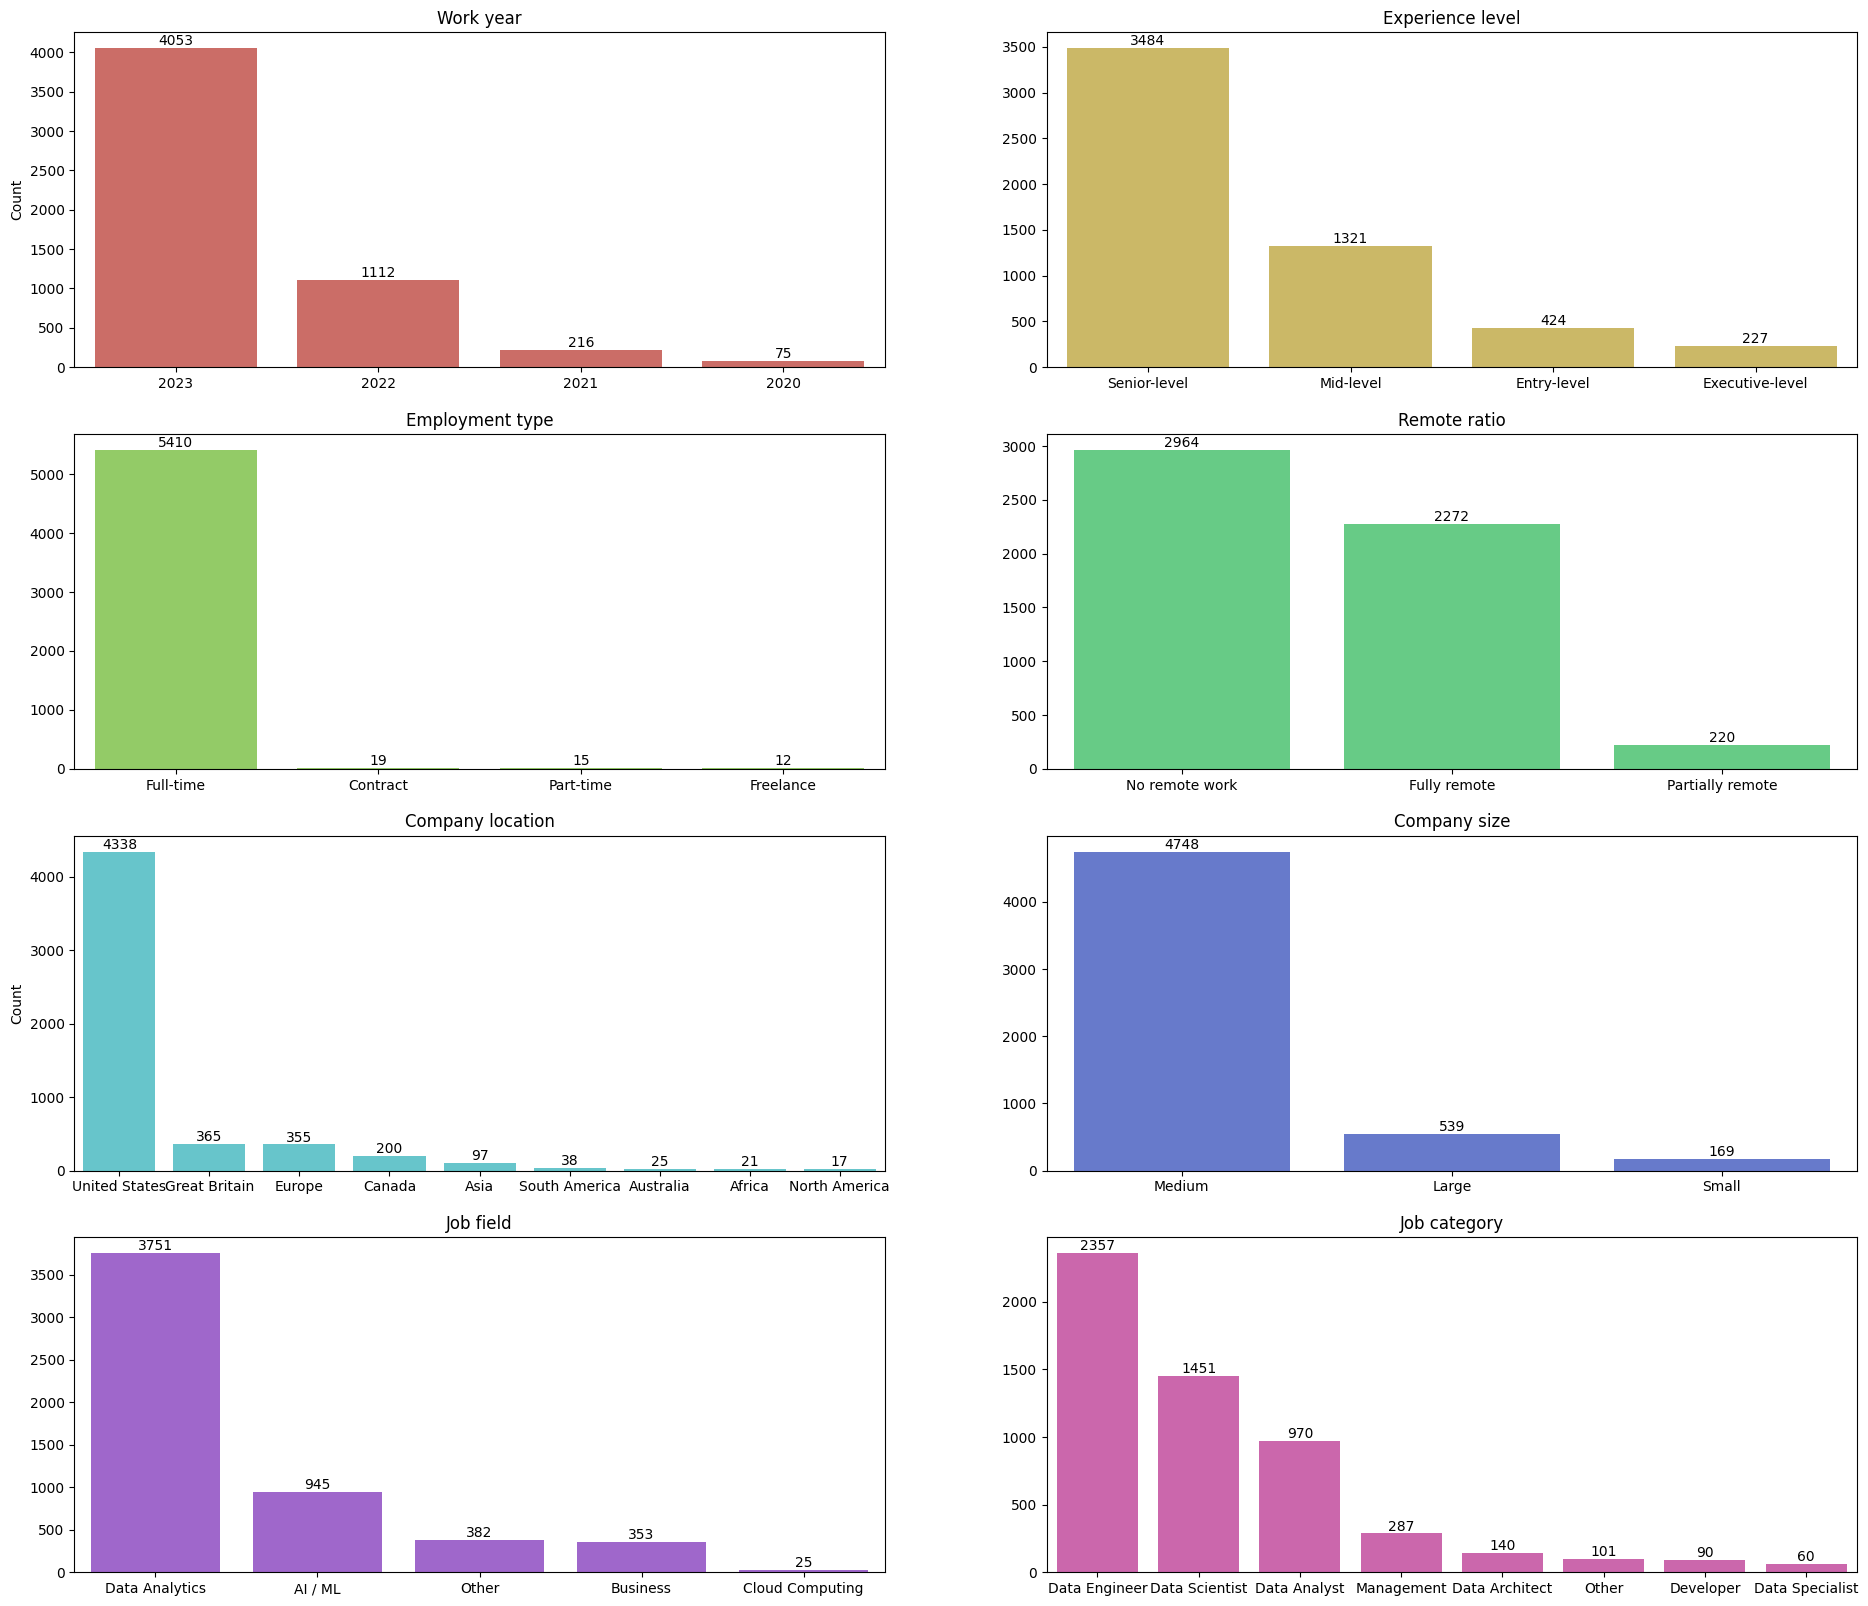

In [11]:
# make subplots
fig, axes = plt.subplots(4, 2, figsize=(23, 20))
ax = axes.flatten()

# choose color scheme
colors = sns.color_palette("hls", 8)

# for each predictor
for i, col in enumerate(predictors.columns):
    # make bar plot of counts
    sns.countplot(data=salaries,
                  x=col,
                  order=salaries[col].value_counts(ascending=False).iloc[:10].index,
                  color=colors[i],
                  ax=ax[i])

    # add counts on top of bars
    ax[i].bar_label(ax[i].containers[0])

    # set title and x-axis labels
    title = col.capitalize().replace("_", " ")
    ax[i].set(title=title)
    ax[i].set(xlabel=None)

    # set y-axis labels
    if i == 0 or i == 4:
        ax[i].set(ylabel="Count")
    else:
        ax[i].set(ylabel=None)

    # add x-axis tick labels
    if title == "Job title":
        ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=35, ha="right", fontsize=10)
    else:
        ax[i].set_xticklabels(ax[i].get_xticklabels(), fontsize=10)

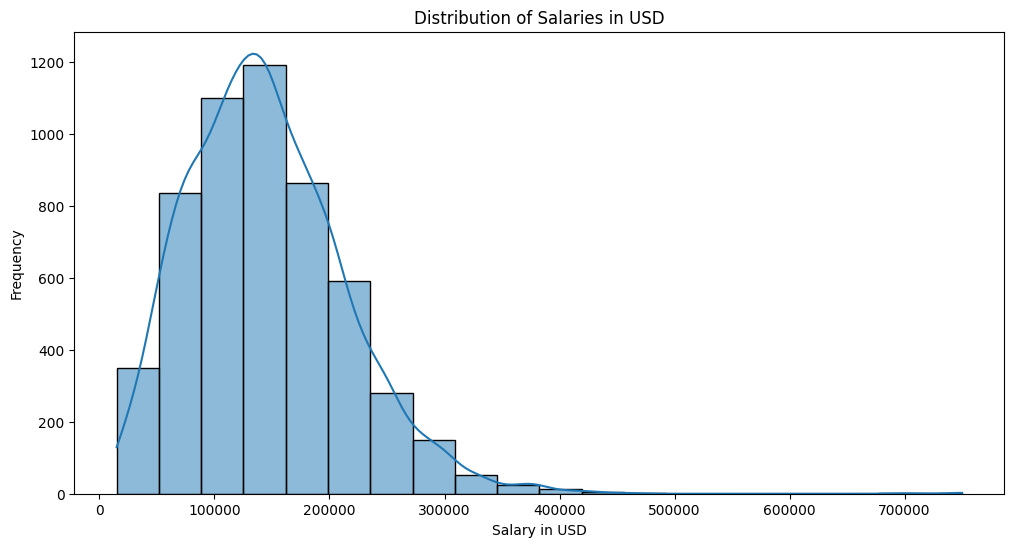

In [12]:
# plot salary distribution
plt.figure(figsize=(12,6))
sns.histplot(salaries['salary_in_usd'], bins=20, kde=True)
plt.title('Distribution of Salaries in USD')
plt.xlabel('Salary in USD')
plt.ylabel('Frequency')
plt.show()

/var/folders/93/9sds1y6s6lsc571jns5mh6f80000gn/T/ipykernel_53704/3969857341.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_xticklabels(ax[i].get_xticklabels(), fontsize=10)
/var/folders/93/9sds1y6s6lsc571jns5mh6f80000gn/T/ipykernel_53704/3969857341.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_xticklabels(ax[i].get_xticklabels(), fontsize=10)
/var/folders/93/9sds1y6s6lsc571jns5mh6f80000gn/T/ipykernel_53704/3969857341.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_xticklabels(ax[i].get_xticklabels(), fontsize=10)
/var/folders/93/9sds1y6s6lsc571jns5mh6f80000gn/T/ipykernel_53704/3969857341.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_xticklabels(ax[i].get_xticklabels(), fontsize=10)
/var/folders/93/9sds1y6s6lsc571jns5mh6f80000gn/T/ipykernel_53704/3969857341.py:33: UserWarning: FixedFormatter should on

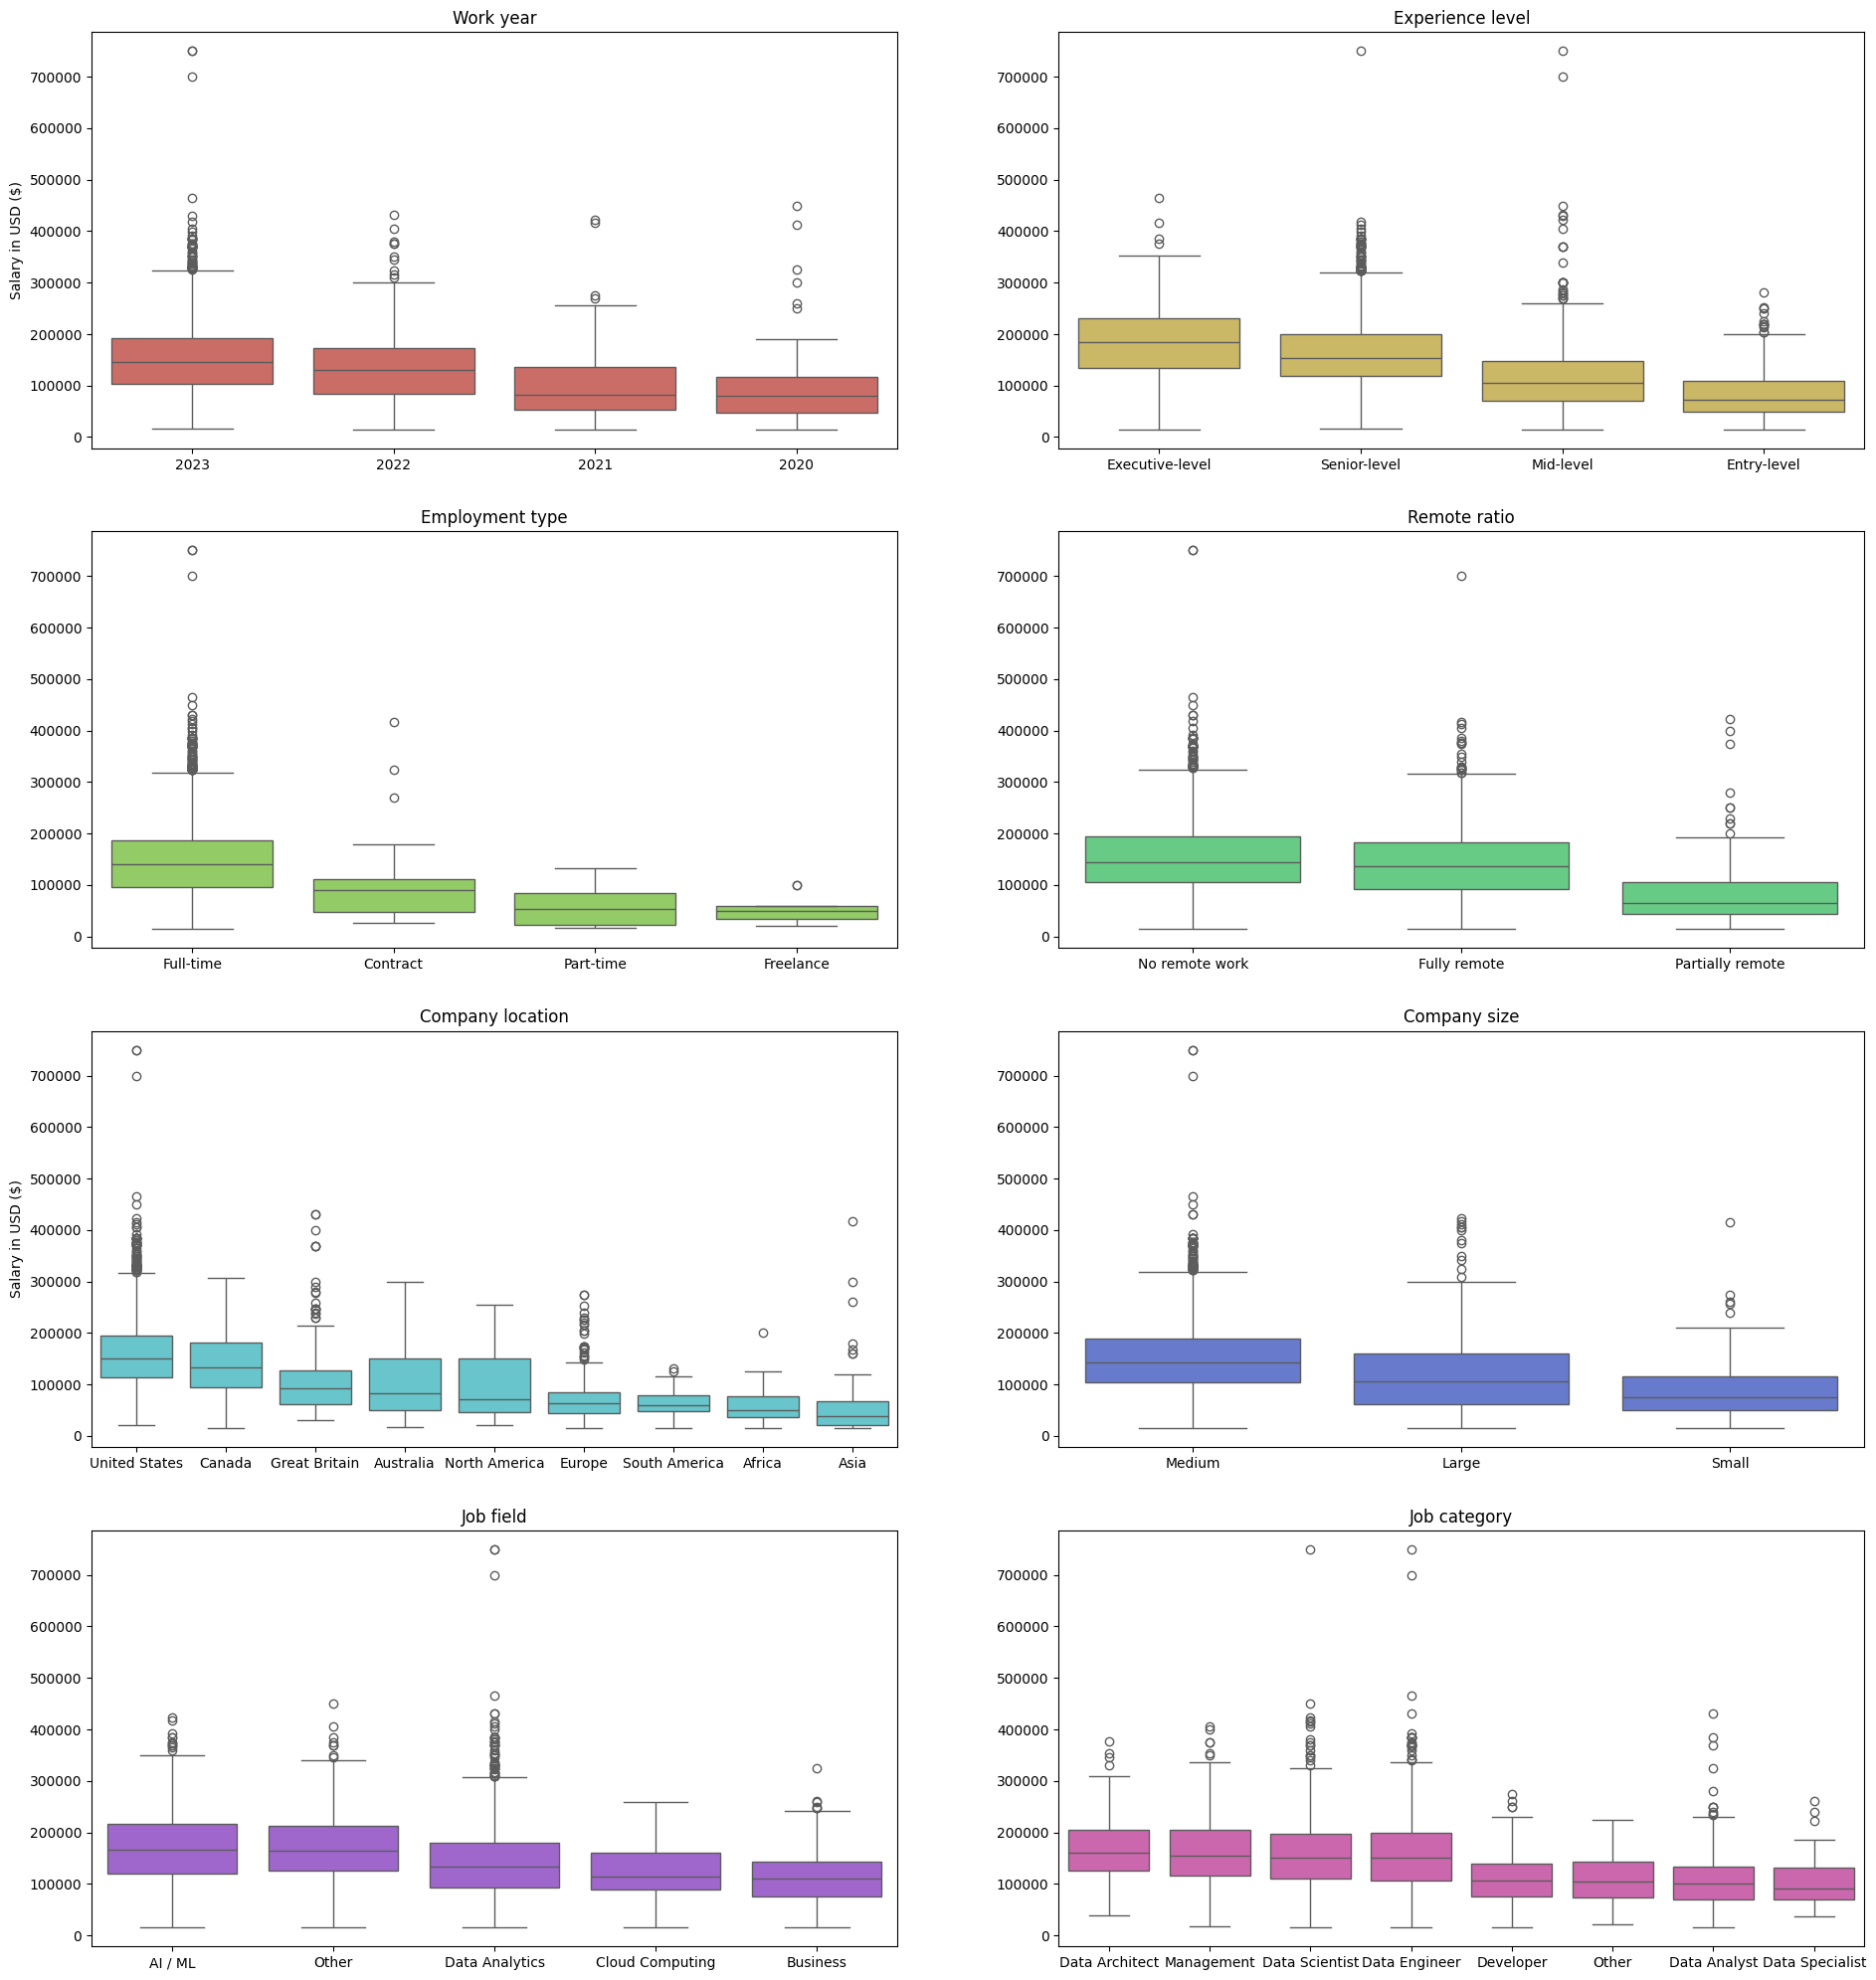

In [13]:
# make subplots
fig, axes = plt.subplots(4, 2, figsize=(23, 25))
ax = axes.flatten()

# choose color schemes
colors = sns.color_palette("hls", 8)

# for each predictor
for i, col in enumerate(predictors.columns):
    # make boxplot of salary vs. the predictor
    sns.boxplot(data=salaries,
                x=col,
                y="salary_in_usd",
                order=salaries.groupby(col).median("salary_in_usd").sort_values(by="salary_in_usd", ascending=False).iloc[:10].index,
                color=colors[i],
                ax=ax[i])

    # set title and x-axis labels
    title = col.capitalize().replace("_", " ")
    ax[i].set(title=title)
    ax[i].set(xlabel=None)

    # set y-axis labels
    if i == 0 or i == 4:
        ax[i].set(ylabel="Salary in USD ($)")
    else:
        ax[i].set(ylabel=None)

    # add x-axis tick labels
    if title == "Job title":
        ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=35, ha="right", fontsize=10)
    else:
        ax[i].set_xticklabels(ax[i].get_xticklabels(), fontsize=10)

<Axes: >

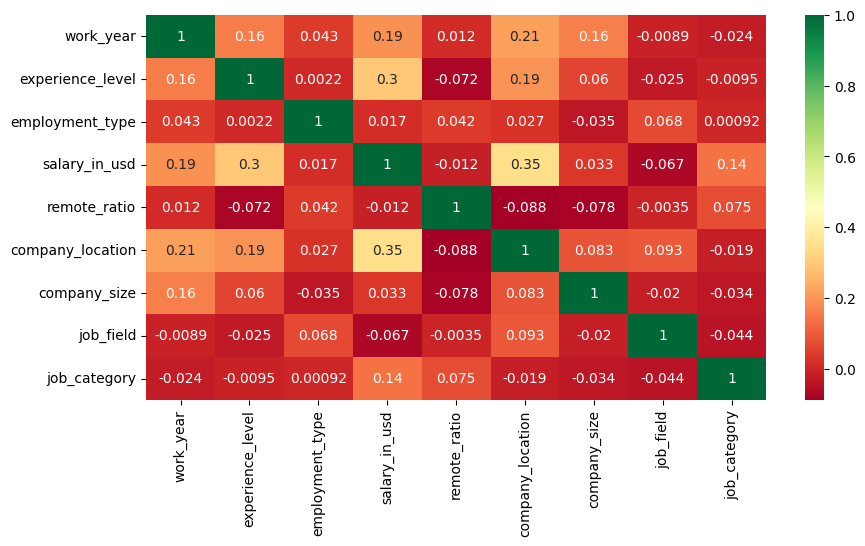

In [14]:
# encode categorical variables
salaries_copy = salaries.copy()
salaries_copy['experience_level'] = salaries_copy['experience_level'].astype('category').cat.codes
salaries_copy['employment_type'] = salaries_copy['employment_type'].astype('category').cat.codes
salaries_copy['remote_ratio'] = salaries_copy['remote_ratio'].astype('category').cat.codes
salaries_copy['job_category'] = salaries_copy['job_category'].astype('category').cat.codes
salaries_copy['job_field'] = salaries_copy['job_field'].astype('category').cat.codes
salaries_copy['company_location'] = salaries_copy['company_location'].astype('category').cat.codes
salaries_copy['company_size'] = salaries_copy['company_size'].astype('category').cat.codes

# plot heatmap
plt.figure(figsize=(10, 5))
c = salaries_copy.corr()
sns.heatmap(c, cmap="RdYlGn", annot=True)

<Axes: >

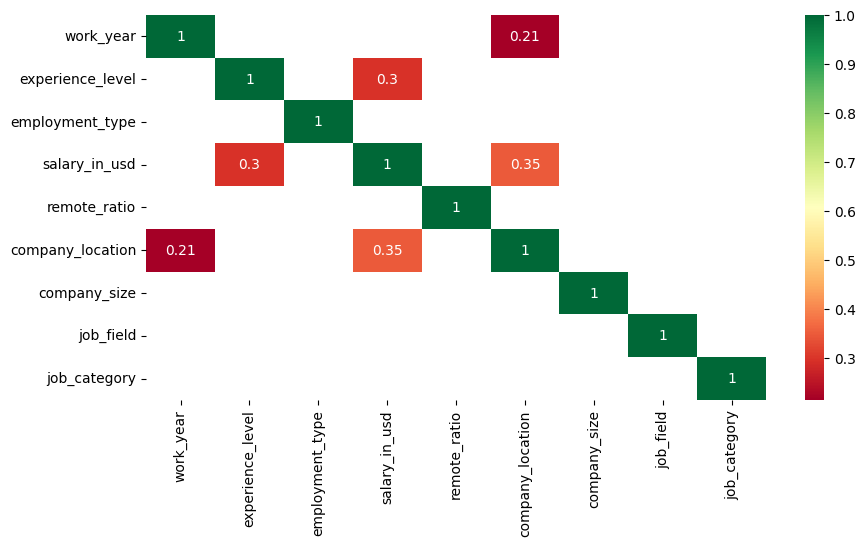

In [15]:
# plot correlation matrix
plt.figure(figsize=(10, 5))
c = salaries_copy.corr()
c[c.abs() < 0.2] = np.nan
sns.heatmap(c, cmap="RdYlGn", annot=True)

There are some comparably high correlations above:

- `company_location` to `salary_in_usd` (0.35)
- `experience_level` to `salary_in_usd` (0.3)
- `company_location` to `work_year` (0.21)

## Modeling

- **Goal:** predict data science salaries (in USD) using variables such as experience level, company size, etc.
- **Models:** dummy regression, linear regression, LASSO regression, random forest, boosted trees, neural network

### Considerations

- **One-hot encoding:** allows our models to use categorical predictors by representing them as numbers
- **Cross-validation:** gives a better estimate of each model's performance by using multiple train-test splits and averaging the errors
- **Hyperparameter tuning:** allows us to test multiple combinations of parameters to find the “best” set
- **Metrics:** since we are predicting salaries (regression), mean absolute error (MAE) and root mean squared error (RMSE) are good metrics

### Data Preparation

In [16]:
# define predictor and target
X = salaries.drop("salary_in_usd", axis=1)
X = pd.get_dummies(X, drop_first=True)
y = salaries["salary_in_usd"]

# create 5-fold CV object
kf = KFold(n_splits=5, shuffle=True, random_state=1)

# get training and test sets for the 1st fold (used for visualization purposes later)
train_indices, test_indices = next(kf.split(X, y))
X_train = X.iloc[train_indices]
X_test = X.iloc[test_indices]
y_train = y.iloc[train_indices]
y_test = y.iloc[test_indices]

In [17]:
X_train # predictors training set

,work_year_2021,work_year_2022,work_year_2023,experience_level_Executive-level,experience_level_Mid-level,experience_level_Senior-level,employment_type_Freelance,employment_type_Full-time,employment_type_Part-time,remote_ratio_No remote work,...,job_field_Cloud Computing,job_field_Data Analytics,job_field_Other,job_category_Data Architect,job_category_Data Engineer,job_category_Data Scientist,job_category_Data Specialist,job_category_Developer,job_category_Management,job_category_Other
0,False,False,True,False,False,True,False,True,False,False,...,False,True,False,False,True,False,False,False,False,False
1,False,False,True,False,False,True,False,True,False,False,...,False,True,False,False,True,False,False,False,False,False
2,False,False,True,False,False,True,False,True,False,True,...,False,True,False,False,False,True,False,False,False,False
6,False,False,True,False,False,True,False,True,False,True,...,False,True,False,False,False,True,False,False,False,False
7,False,False,True,False,False,True,False,True,False,True,...,False,True,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9490,True,False,False,False,False,True,False,True,False,True,...,False,True,False,False,False,False,False,False,True,False
9491,True,False,False,False,True,False,False,True,False,False,...,False,True,False,False,False,True,False,False,False,False
9492,True,False,False,False,True,False,False,True,False,False,...,False,False,False,False,False,True,False,False,False,False
9493,True,False,False,False,True,False,False,True,False,False,...,False,True,False,False,True,False,False,False,False,False


In [18]:
y_train # target test set

0       196000
1        94000
2       264846
6        64781
7        41027
         ...  
9490    168000
9491    119059
9492    423000
9493     28369
9498    100000
Name: salary_in_usd, Length: 4364, dtype: int64

### Model #1: Dummy Regression

- **Explanation:** predicts the mean of the target variable for every observation
- **Purpose:** acts as a baseline model since no patterns are being learned

In [19]:
# define dummy model
dummy_model = DummyRegressor(strategy="mean")

# perform cross-validation
dummy_cv_results = pd.DataFrame(
    cross_validate(dummy_model, 
                   X, 
                   y, 
                   cv=kf, 
                   return_train_score=True, 
                   return_estimator=True, 
                   scoring=["neg_mean_absolute_error", "neg_root_mean_squared_error"])
)

# output results
dummy_cv_results = dummy_cv_results.drop(["fit_time", "score_time", "estimator"], axis=1)
dummy_cv_results = dummy_cv_results.mean() * -1
dummy_cv_results = pd.DataFrame(dummy_cv_results, columns=["dummy_cv"])
dummy_cv_results.index = ["test_mae_avg", "train_mae_avg", "test_rmse_avg", "train_rmse_avg"]
dummy_cv_results

,dummy_cv
test_mae_avg,53813.180222
train_mae_avg,53793.468421
test_rmse_avg,68989.733389
train_rmse_avg,68988.669716


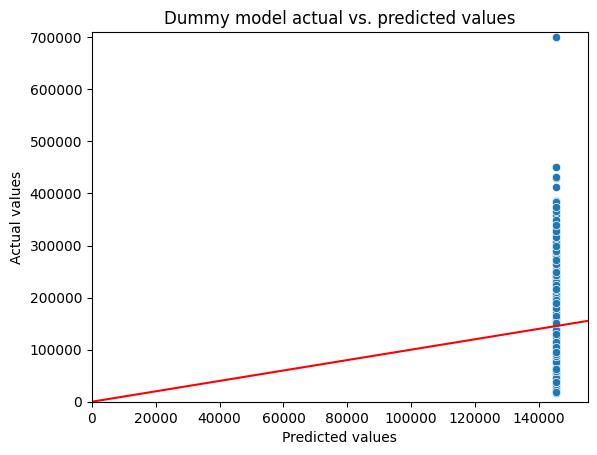

In [20]:
# fit model and make predictions
dummy_model = DummyRegressor(strategy="mean")
dummy_model.fit(X_train, y_train)
y_pred = dummy_model.predict(X_test)

# plot actual vs. predicted values
sns.scatterplot(x=y_pred, y=y_test)
plt.xlim(0, max(y_pred) + 10000)
plt.ylim(0, max(y_test) + 10000)
plt.xlabel("Predicted values")
plt.ylabel("Actual values")
plt.title("Dummy model actual vs. predicted values")
plt.plot([0, max(y_test)], [0, max(y_test)], "r")

### Model #2: Linear Regression

- **Explanation:** fits a straight line through the points 
- **Purpose:** has interpretable coefficients, acts as another good baseline model due to simplicity

In [21]:
# define model
lm_model = LinearRegression()

# perform cross-validation
lm_cv_results = pd.DataFrame(
    cross_validate(lm_model, 
                   X, 
                   y, 
                   cv=kf, 
                   return_train_score=True, 
                   return_estimator=True,
                   scoring=["neg_mean_absolute_error", "neg_root_mean_squared_error"])
)

# output results
lm_cv_results = lm_cv_results.drop(["fit_time", "score_time", "estimator"], axis=1)
lm_cv_results = lm_cv_results.mean() * -1
lm_cv_results = pd.DataFrame(lm_cv_results, columns=["linear_cv"])
lm_cv_results.index = ["test_mae_avg", "train_mae_avg", "test_rmse_avg", "train_rmse_avg"]
lm_cv_results

,linear_cv
test_mae_avg,41381.359833
train_mae_avg,41030.051241
test_rmse_avg,55509.230202
train_rmse_avg,55031.376211


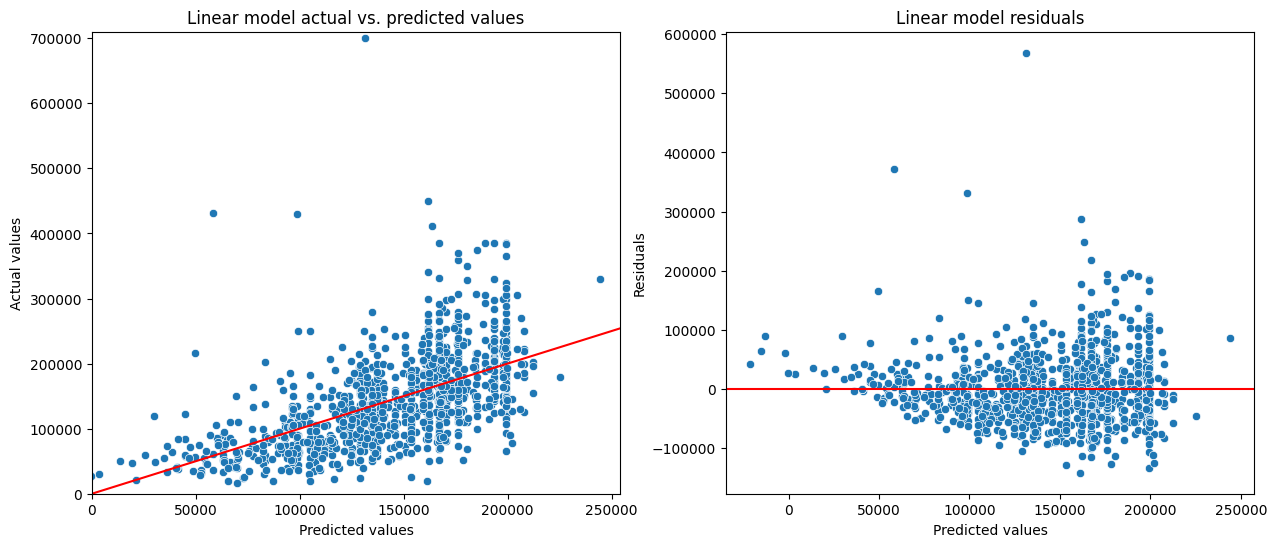

In [22]:
# fit model and make predictions
lm_model = LinearRegression()
lm_model.fit(X_train, y_train)
y_pred = lm_model.predict(X_test)

# make subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
ax = axes.flatten()

# plot actual vs. predicted values
sns.scatterplot(x=y_pred, y=y_test, ax=ax[0])
ax[0].set_xlim(0, max(y_pred) + 10000)
ax[0].set_ylim(0, max(y_test) + 10000)
ax[0].set_xlabel("Predicted values")
ax[0].set_ylabel("Actual values")
ax[0].set_title("Linear model actual vs. predicted values")
ax[0].plot([0, max(y_test)], [0, max(y_test)], "r")

# plot residuals
residuals = y_test - y_pred
sns.scatterplot(x=y_pred, y=residuals, ax=ax[1])
ax[1].set_xlabel("Predicted values")
ax[1].set_ylabel("Residuals")
ax[1].set_title("Linear model residuals")
ax[1].axhline(y=0, color="r")

In [23]:
# show intercept
lm_model.intercept_

63760.94720830995

In [24]:
# show sorted coefficient estimates
pd.DataFrame(lm_model.coef_, X.columns, columns=['Coefficient']).sort_values("Coefficient", ascending=False)

,Coefficient
experience_level_Executive-level,83323.776156
experience_level_Senior-level,51495.868648
company_location_United States,47530.452030
company_location_Australia,46139.237258
job_category_Management,45648.716897
job_category_Data Architect,43499.526991
job_category_Data Scientist,41016.056761
company_location_Canada,33061.791964
job_category_Data Engineer,32288.852697
experience_level_Mid-level,21427.628620


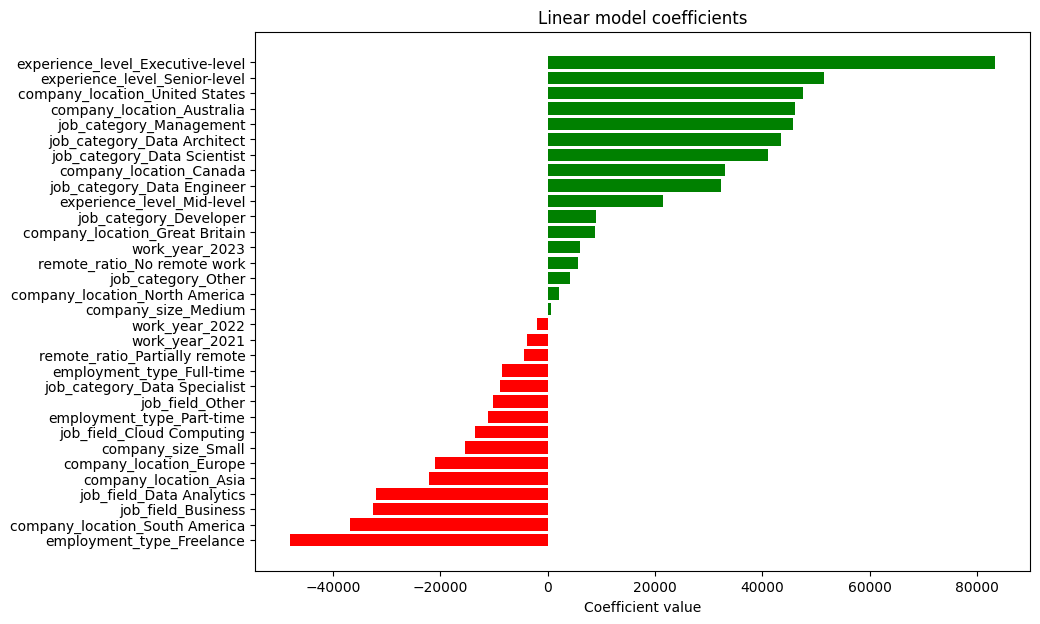

In [25]:
# plot coefficient estimates
lm_features = X.columns
lm_coefs = lm_model.coef_
lm_colors = np.array(["green" if coef > 0 else "red" for coef in lm_model.coef_])
lm_indices = np.argsort(lm_coefs)

plt.figure(figsize=(10, 7))
plt.title("Linear model coefficients")
plt.barh(range(len(lm_indices)), lm_coefs[lm_indices], color=lm_colors[lm_indices], align="center")
plt.yticks(range(len(lm_indices)), [lm_features[i] for i in lm_indices])
plt.xlabel("Coefficient value")
plt.show()

Based on the coefficient estimates, it appears that experience level, company location, job category, and to some extent employment type have the most significant effects on salaries. For example:

- Having a executive-level or senior-level position can lead to a salary increase of \$83,323.78 and \$51,495.87, respectively.
- If the company is located in the United States, then the salary is predicted to increase by \$47,530.45.
- Working in a data management job can increase one's salary by \$45,648.72.
- Being a freelancer is associated with a salary decrease of \$47,912.14.

### Model #3: LASSO Regression

- **Explanation:** linear regression with regularization (shrinks coefficient estimates towards 0)
- **Purpose:** reduces variance at the cost of increased bias, is also good for variable selection

In [26]:
# define model
lasso_model = LassoCV(n_alphas=1000)

# perform cross-validation
lasso_cv = pd.DataFrame(
    cross_validate(lasso_model, 
                   X, 
                   y, 
                   cv=kf, 
                   return_train_score=True, 
                   return_estimator=True,
                   scoring=["neg_mean_absolute_error", "neg_root_mean_squared_error"],
                   verbose=1)
)

# show chosen alpha value for each fold
for i in range(5):
    print(f"Alpha for fold {i}: {lasso_cv.estimator[i].alpha_}")

Alpha for fold 0: 87.19936067088149
Alpha for fold 1: 13.377703834418131
Alpha for fold 2: 43.67836244966341
Alpha for fold 3: 80.94003666493782
Alpha for fold 4: 13.151313150908784


In [27]:
# output results
lasso_cv_results = lasso_cv.drop(["fit_time", "score_time", "estimator"], axis=1)
lasso_cv_results = lasso_cv_results.mean() * -1
lasso_cv_results = pd.DataFrame(lasso_cv_results, columns=["lasso_cv"])
lasso_cv_results.index = ["test_mae_avg", "train_mae_avg", "test_rmse_avg", "train_rmse_avg"]
lasso_cv_results

,lasso_cv
test_mae_avg,41377.526233
train_mae_avg,41054.992270
test_rmse_avg,55498.416245
train_rmse_avg,55084.467081


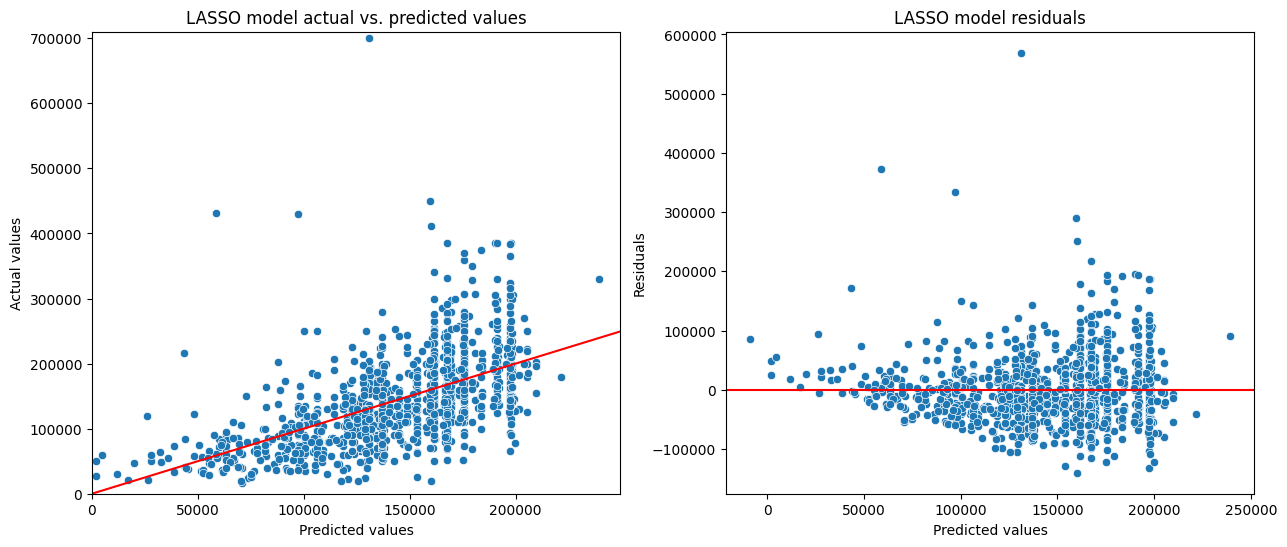

In [28]:
# make predictions
lasso_model = lasso_cv.estimator[0]
y_pred = lasso_model.predict(X_test)

# make subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
ax = axes.flatten()

# plot actual vs. predicted values
sns.scatterplot(x=y_pred, y=y_test, ax=ax[0])
ax[0].set_xlim(0, max(y_pred) + 10000)
ax[0].set_ylim(0, max(y_test) + 10000)
ax[0].set_xlabel("Predicted values")
ax[0].set_ylabel("Actual values")
ax[0].set_title("LASSO model actual vs. predicted values")
ax[0].plot([0, max(y_test)], [0, max(y_test)], "r")

# plot residuals
residuals = y_test - y_pred
sns.scatterplot(x=y_pred, y=residuals, ax=ax[1])
ax[1].set_xlabel("Predicted values")
ax[1].set_ylabel("Residuals")
ax[1].set_title("LASSO model residuals")
ax[1].axhline(y=0, color="r")

In [29]:
# show sorted coefficient estimates
pd.DataFrame(lasso_model.coef_, X.columns, columns=["Coefficient"]).sort_values("Coefficient")

,Coefficient
company_location_South America,-31187.164149
job_field_Data Analytics,-29752.561372
job_field_Business,-29374.996468
company_location_Europe,-27902.211240
company_location_Asia,-27104.704306
company_size_Small,-13598.647606
job_field_Other,-7116.957744
remote_ratio_Partially remote,-3555.942276
job_category_Data Specialist,-2528.243008
employment_type_Freelance,-1150.005088


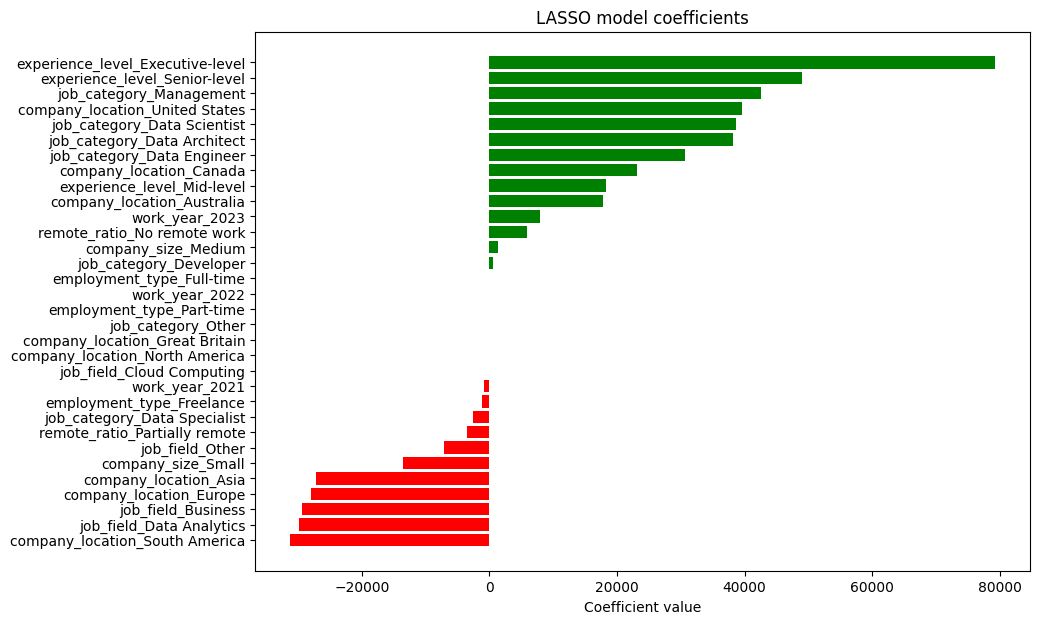

In [30]:
# plot coefficient estimates
lasso_features = X.columns
lasso_coefs = lasso_model.coef_
lasso_colors = np.array(["green" if coef > 0 else "red" for coef in lasso_coefs])
lasso_indices = np.argsort(lasso_coefs)

plt.figure(figsize=(10, 7))
plt.title("LASSO model coefficients")
plt.barh(range(len(lasso_indices)), lasso_coefs[lasso_indices], color=lasso_colors[lasso_indices], align="center")
plt.yticks(range(len(lasso_indices)), [lasso_features[i] for i in lasso_indices])
plt.xlabel("Coefficient value")
plt.show()

- The interpretation of this model is very similar to what we saw for the linear regression model: experience level, company location, and job category play a big role in determining compensation.
- There were 6 variables that were dropped (have coefficients of 0), 2 of which are associated with company location (North America and Great Britain).

### Model #4: Random Forest

- **Explanation:** fits many independent trees to the data
- **Purpose:** tends to generalize well to new data due to nonlinearity, has feature importance

In [31]:
# define hyperparameter grid
rf_param_grid = {
    "n_estimators": list(range(100, 501, 100)),
    "max_depth": list(range(3, 11)),
    "max_features": [1.0, "sqrt", "log2"]
}

# perform cross-validation using hyperparameters
rf = RandomForestRegressor(random_state=1, n_jobs=4)
rf_gs = GridSearchCV(rf, 
                     rf_param_grid, 
                     cv=kf, 
                     refit=False, 
                     scoring=["neg_mean_absolute_error", "neg_root_mean_squared_error"], 
                     return_train_score=True, 
                     verbose=1)
rf_gs.fit(X, y)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
             estimator=RandomForestRegressor(n_jobs=4, random_state=1),
             param_grid={'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
                         'max_features': [1.0, 'sqrt', 'log2'],
                         'n_estimators': [100, 200, 300, 400, 500]},
             refit=False, return_train_score=True,
             scoring=['neg_mean_absolute_error', 'neg_root_mean_squared_error'],
             verbose=1)

In [32]:
# output results
rf_cv_results = pd.DataFrame(rf_gs.cv_results_)
rf_cv_results = rf_cv_results.sort_values("mean_test_neg_root_mean_squared_error", ascending=False)
rf_cv_results = pd.DataFrame(rf_cv_results[["mean_test_neg_mean_absolute_error", "mean_train_neg_mean_absolute_error", "mean_train_neg_root_mean_squared_error", "mean_train_neg_root_mean_squared_error"]].iloc[0, :])
rf_cv_results = rf_cv_results * -1
rf_cv_results.columns = ["rf_cv"]
rf_cv_results.index = ["test_mae_avg", "train_mae_avg", "test_rmse_avg", "train_rmse_avg"]
rf_cv_results

,rf_cv
test_mae_avg,41260.309760
train_mae_avg,39217.376217
test_rmse_avg,52729.752517
train_rmse_avg,52729.752517


In [33]:
# show best hyperparameters in terms of MAE
rf_best_params = pd.DataFrame(rf_gs.cv_results_).sort_values("mean_test_neg_mean_absolute_error", ascending=False).params.iloc[0]
rf_best_params

{'max_depth': 7, 'max_features': 1.0, 'n_estimators': 200}

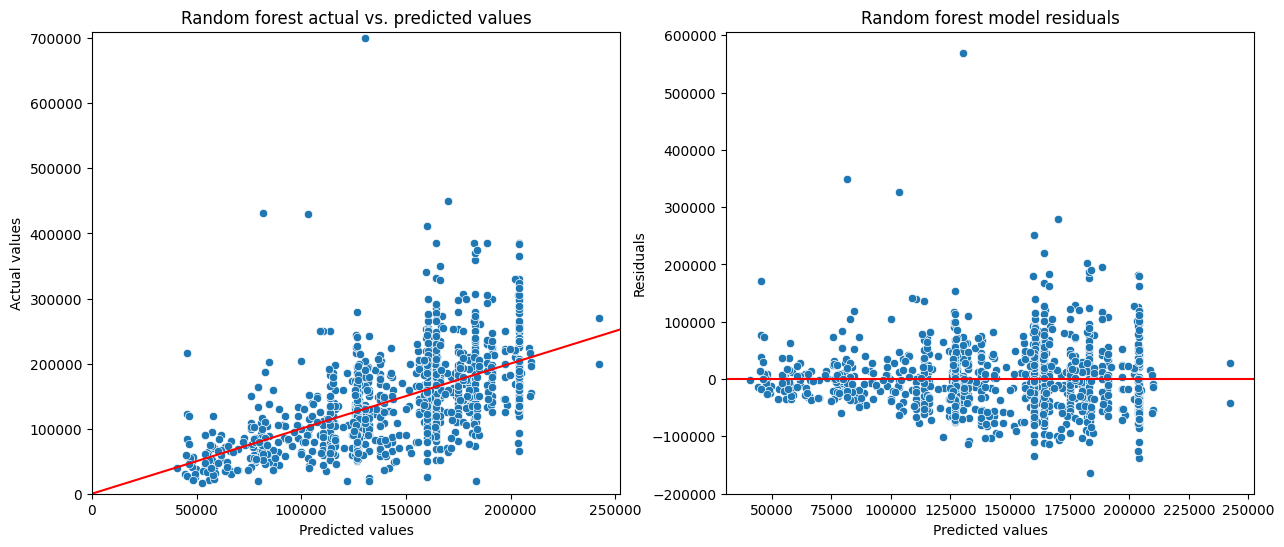

In [34]:
# fit model
rf_model = RandomForestRegressor(**rf_best_params, random_state=1, n_jobs=4)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

# make subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
ax = axes.flatten()

# plot actual vs. predicted values
sns.scatterplot(x=y_pred, y=y_test, ax=ax[0])
ax[0].set_xlim(0, max(y_pred) + 10000)
ax[0].set_ylim(0, max(y_test) + 10000)
ax[0].set_xlabel("Predicted values")
ax[0].set_ylabel("Actual values")
ax[0].set_title("Random forest actual vs. predicted values")
ax[0].plot([0, max(y_test)], [0, max(y_test)], "r")

# plot residuals
residuals = y_test - y_pred
sns.scatterplot(x=y_pred, y=residuals, ax=ax[1])
ax[1].set_xlabel("Predicted values")
ax[1].set_ylabel("Residuals")
ax[1].set_title("Random forest model residuals")
ax[1].axhline(y=0, color="r")

In [35]:
# show sorted feature importances
pd.DataFrame(rf_model.feature_importances_, X.columns, columns=["Importance"]).sort_values("Importance", ascending=False)

,Importance
company_location_United States,0.319051
experience_level_Senior-level,0.124004
experience_level_Executive-level,0.098693
job_field_Data Analytics,0.066099
job_field_Business,0.051099
job_category_Data Scientist,0.043705
job_category_Data Engineer,0.042344
company_location_Canada,0.030872
remote_ratio_No remote work,0.029522
job_category_Management,0.025278


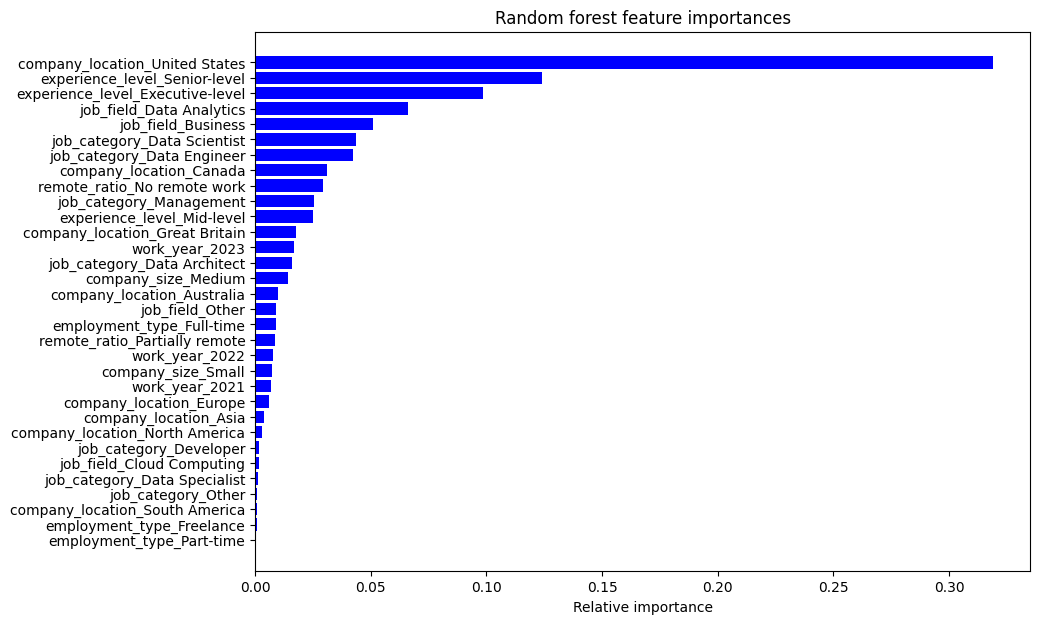

In [36]:
# plot feature importances
rf_features = X.columns
rf_importances = rf_model.feature_importances_
rf_indices = np.argsort(rf_importances)

plt.figure(figsize=(10, 7))
plt.title("Random forest feature importances")
plt.barh(range(len(rf_indices)), rf_importances[rf_indices], color="b", align="center")
plt.yticks(range(len(rf_indices)), [rf_features[i] for i in rf_indices])
plt.xlabel("Relative importance")
plt.show()

Based on the feature importances, company location, experience level, job field, and job category appear to have the most influence on the predicted salaries.

### Model #5: Boosted Trees

- **Explanation:** fits many consecutive trees to the residuals
- **Purpose:** tends to generalize well to new data due to nonlinearity, has feature importance

In [37]:
# define hyperparameter grid
gb_param_grid = {
    "n_estimators": list(range(100, 501, 100)),
    "max_depth": range(3, 11),
    "learning_rate": [0.001, 0.01, 0.1]
}

# perform cross-validation using hyperparameters
gb = GradientBoostingRegressor(subsample=0.8, random_state=1)
gb_gs = GridSearchCV(gb, 
                     gb_param_grid, 
                     cv=kf, 
                     refit=False, 
                     scoring=["neg_mean_absolute_error", "neg_root_mean_squared_error"], 
                     return_train_score=True, 
                     verbose=1)
gb_gs.fit(X, y)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
             estimator=GradientBoostingRegressor(random_state=1, subsample=0.8),
             param_grid={'learning_rate': [0.001, 0.01, 0.1],
                         'max_depth': range(3, 11),
                         'n_estimators': [100, 200, 300, 400, 500]},
             refit=False, return_train_score=True,
             scoring=['neg_mean_absolute_error', 'neg_root_mean_squared_error'],
             verbose=1)

In [38]:
# organize results
gb_cv_results = pd.DataFrame(gb_gs.cv_results_)
gb_cv_results = gb_cv_results.sort_values("mean_test_neg_root_mean_squared_error", ascending=False)
gb_cv_results = pd.DataFrame(gb_cv_results[["mean_test_neg_mean_absolute_error", "mean_train_neg_mean_absolute_error", "mean_train_neg_root_mean_squared_error", "mean_train_neg_root_mean_squared_error"]].iloc[0, :])
gb_cv_results = gb_cv_results * -1
gb_cv_results.columns = ["gb_cv"]
gb_cv_results.index = ["test_mae_avg", "train_mae_avg", "test_rmse_avg", "train_rmse_avg"]
gb_cv_results

,gb_cv
test_mae_avg,40949.912097
train_mae_avg,38735.669027
test_rmse_avg,52301.409345
train_rmse_avg,52301.409345


In [39]:
# best hyperparameters in terms of MAE
gb_best_params = pd.DataFrame(gb_gs.cv_results_).sort_values("mean_test_neg_mean_absolute_error", ascending=False).params.iloc[0]
gb_best_params

{'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 500}

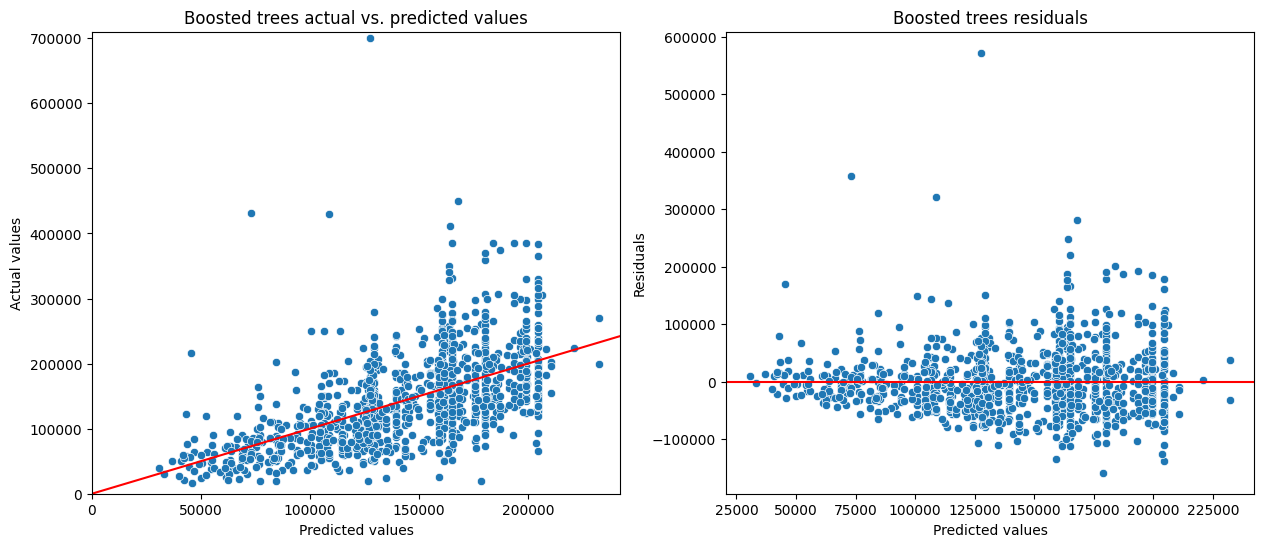

In [40]:
# fit model
gb_model = GradientBoostingRegressor(**gb_best_params, subsample=0.8, random_state=1)
gb_model.fit(X_train, y_train)
y_pred = gb_model.predict(X_test)

# make subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
ax = axes.flatten()

# plot actual vs. predicted values
sns.scatterplot(x=y_pred, y=y_test, ax=ax[0])
ax[0].set_xlim(0, max(y_pred) + 10000)
ax[0].set_ylim(0, max(y_test) + 10000)
ax[0].set_xlabel("Predicted values")
ax[0].set_ylabel("Actual values")
ax[0].set_title("Boosted trees actual vs. predicted values")
ax[0].plot([0, max(y_test)], [0, max(y_test)], "r")

# plot residuals
residuals = y_test - y_pred
sns.scatterplot(x=y_pred, y=residuals, ax=ax[1])
ax[1].set_xlabel("Predicted values")
ax[1].set_ylabel("Residuals")
ax[1].set_title("Boosted trees residuals")
ax[1].axhline(y=0, color="r")

In [41]:
# show sorted feature importances
pd.DataFrame(gb_model.feature_importances_, X.columns, columns=["Importance"]).sort_values("Importance", ascending=False)

,Importance
company_location_United States,0.291170
experience_level_Senior-level,0.116333
experience_level_Executive-level,0.091701
job_field_Data Analytics,0.065722
job_category_Data Scientist,0.055562
job_category_Data Engineer,0.045098
job_field_Business,0.041057
job_category_Management,0.035165
company_location_Canada,0.030436
remote_ratio_No remote work,0.028101


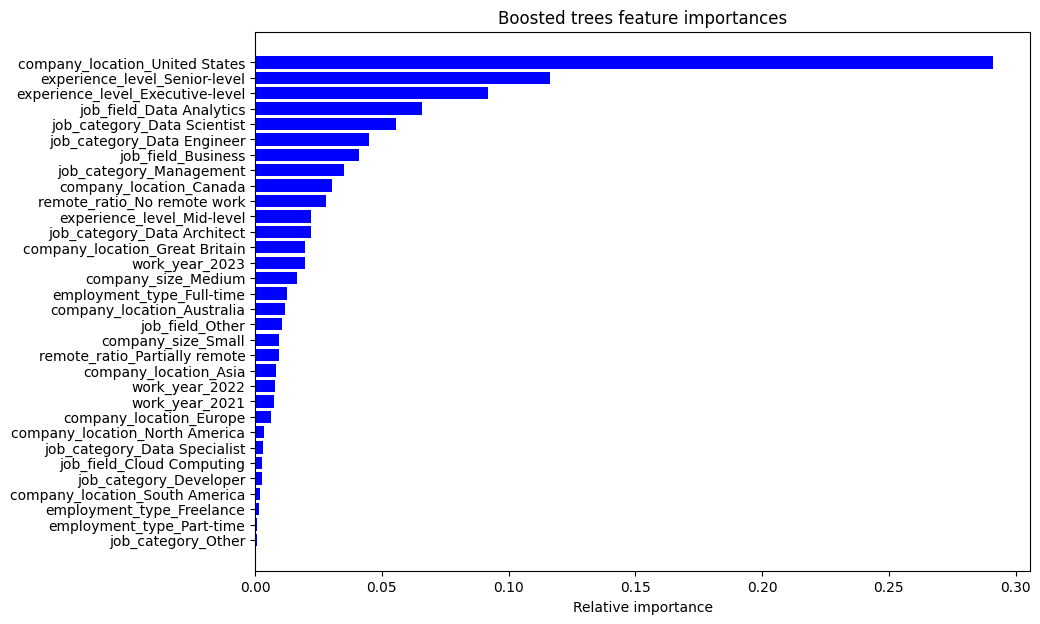

In [42]:
# plot feature importances
gb_features = X.columns
gb_importances = gb_model.feature_importances_
gb_indices = np.argsort(gb_importances)

plt.figure(figsize=(10, 7))
plt.title("Boosted trees feature importances")
plt.barh(range(len(gb_indices)), gb_importances[gb_indices], color="b", align="center")
plt.yticks(range(len(gb_indices)), [gb_features[i] for i in gb_indices])
plt.xlabel("Relative importance")
plt.show()

Like the random forest model, company location, experience level, job field, and job category seem to have the biggest effect in determining data science salaries.

### Model #6: Neural Network

- **Explanation:** passes values through layers and adjusts predictions based on a loss function
- **Purpose:** tends to generalize well to new data due to nonlinearity

In [43]:
# define neural network architecture
class NN(nn.Module):
    def __init__(self, input_size, hidden_size_1, hidden_size_2, hidden_size_3, hidden_size4):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size_1)
        self.dropout1 = nn.Dropout(0.2)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size_1, hidden_size_2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size_2, hidden_size_3)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(hidden_size_3, hidden_size4)
        self.fc5 = nn.Linear(hidden_size4, 1)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.dropout1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        out = self.relu3(out)
        out = self.fc4(out)
        out = self.fc5(out)

        return out

In [44]:
# define parameters
input_size = X.shape[1]
hidden_size_1 = 128
hidden_size_2 = 64
hidden_size_3 = 32
hidden_size_4 = 32
learning_rate = 0.005
batch_size = 16
num_epochs = 100

We first train the neural network using MAE as the loss function.

In [45]:
# initialize model, loss function, and optimizer
nn_model = NN(input_size, hidden_size_1, hidden_size_2, hidden_size_3, hidden_size_4)
mae = nn.L1Loss()
optimizer = Adam(nn_model.parameters(), lr=learning_rate)

# set seed for reproducibility
torch.manual_seed(0)

# initialize lists
all_train_mae_avg = []
all_test_mae_avg = []

for i, (train_indices, test_indices) in enumerate(kf.split(X, y)):
    # get training and test sets
    X_train = X.iloc[train_indices]
    X_test = X.iloc[test_indices]
    y_train = y.iloc[train_indices]
    y_test = y.iloc[test_indices]

    # transform data to tensors
    X_train_tensor = torch.from_numpy(X_train.values.astype(np.float32))
    X_test_tensor = torch.from_numpy(X_test.values.astype(np.float32))
    y_train_tensor = torch.from_numpy(y_train.values.astype(np.float32))
    y_test_tensor = torch.from_numpy(y_test.values.astype(np.float32))

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    # create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    # initialize lists
    all_train_mae = []
    all_test_mae = []

    print("-" * 60)
    print(f"Fold {i + 1}")

    for epoch in range(num_epochs):
        ### TRAINING
        nn_model.train()

        # initialize training loss
        total_train_mae = 0.0

        for X_train_batch, y_train_batch in train_loader:
            # forward pass and calculate training loss
            y_train_pred = nn_model(X_train_batch).squeeze(1)
            train_mae = mae(y_train_pred, y_train_batch)

            # backward and optimize
            optimizer.zero_grad()
            train_mae.backward()
            optimizer.step()

            # accumulate training loss for the current batch
            total_train_mae += train_mae.item()
        
        # calculate average training loss across all batches
        avg_train_mae = total_train_mae / len(train_loader)
        all_train_mae.append(avg_train_mae)

        ### TESTING
        nn_model.eval()

        # initialize test loss
        total_test_mae = 0.0

        with torch.no_grad():
            for X_test_batch, y_test_batch in test_loader:
                # calculate test loss
                y_test_pred = nn_model(X_test_batch).squeeze(1)
                test_mae = mae(y_test_pred, y_test_batch)

                # accumalate test loss for the current batch
                total_test_mae += test_mae.item()
        
        # calculate average test loss across all batches
        avg_test_mae = total_test_mae / len(test_loader)
        all_test_mae.append(avg_test_mae)
        
        # output progress
        if (epoch + 1) % 10 == 0:
            print("Epoch: {:3d} | Train MAE: {:6.3f} | Test MAE: {:6.3f}" \
                .format(epoch + 1, avg_train_mae, avg_test_mae))
    
    # append average losses to lists
    all_train_mae_avg.append(avg_train_mae)
    all_test_mae_avg.append(avg_test_mae)

print("-" * 60)

------------------------------------------------------------
Fold 1
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Epoch:  10 | Train MAE: 40984.143 | Test MAE: 41166.694
Epoch:  20 | Train MAE: 41211.805 | Test MAE: 41198.991
Epoch:  30 | Train MAE: 40509.387 | Test MAE: 40928.236
Epoch:  40 | Train MAE: 40517.772 | Test MAE: 40964.292
Epoch:  50 | Train MAE: 40349.077 | Test MAE: 41034.909
Epoch:  60 | Train MAE: 40188.384 | Test MAE: 42106.727
Epoch:  70 | Train MAE: 40183.729 | Test MAE: 41364.056
Epoch:  80 | Train MAE: 39898.884 | Test MAE: 42390.790
Epoch:  90 | Train MAE: 40053.882 | Test MAE: 40921.214
Epoch: 100 | Train MAE: 39959.194 | Test MAE: 43067.933
------------------------------------------------------------
Fold 2
Epoch:  10 | Train MAE: 39559.589 | Test MAE: 40244.23

We then train the neural network using RMSE as the loss function.

In [46]:
# initialize model, loss function, and optimizer
nn_model = NN(input_size, hidden_size_1, hidden_size_2, hidden_size_3, hidden_size_4)
mse = nn.MSELoss()
optimizer = Adam(nn_model.parameters(), lr=learning_rate)

# set seed for reproducibility
torch.manual_seed(0)

# initialize lists
all_train_rmse_avg = []
all_test_rmse_avg = []

for i, (train_indices, test_indices) in enumerate(kf.split(X, y)):
    # get training and test sets
    X_train = X.iloc[train_indices]
    X_test = X.iloc[test_indices]
    y_train = y.iloc[train_indices]
    y_test = y.iloc[test_indices]

    # transform data to tensors
    X_train_tensor = torch.from_numpy(X_train.values.astype(np.float32))
    X_test_tensor = torch.from_numpy(X_test.values.astype(np.float32))
    y_train_tensor = torch.from_numpy(y_train.values.astype(np.float32))
    y_test_tensor = torch.from_numpy(y_test.values.astype(np.float32))

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    # create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    # initialize lists
    all_train_rmse = []
    all_test_rmse = []

    print("-" * 60)
    print(f"Fold {i + 1}")

    for epoch in range(num_epochs):
        ### TRAINING
        nn_model.train()

        # initialize training loss
        total_train_rmse = 0.0

        for X_train_batch, y_train_batch in train_loader:
            # forward pass and calculate training loss
            y_train_pred = nn_model(X_train_batch).squeeze(1)
            train_rmse = torch.sqrt(mse(y_train_pred, y_train_batch))

            # backward and optimize
            optimizer.zero_grad()
            train_rmse.backward()
            optimizer.step()

            # accumulate training loss for the current batch
            total_train_rmse += train_rmse.item()
        
        # calculate average training loss across all batches
        avg_train_rmse = total_train_rmse / len(train_loader)
        all_train_rmse.append(avg_train_rmse)

        ### TESTING
        nn_model.eval()

        # initialize test loss
        total_test_rmse = 0.0

        with torch.no_grad():
            for X_test_batch, y_test_batch in test_loader:
                # calculate test loss
                y_test_pred = nn_model(X_test_batch).squeeze(1)
                test_rmse = torch.sqrt(mse(y_test_pred, y_test_batch))

                # accumalate test loss for the current batch
                total_test_rmse += test_rmse.item()
        
        # calculate average test loss across all batches
        avg_test_rmse = total_test_rmse / len(test_loader)
        all_test_rmse.append(avg_test_rmse)
        
        # output progress
        if (epoch + 1) % 10 == 0:
            print("Epoch: {:3d} | Train RMSE: {:6.3f} | Test RMSE: {:6.3f}" \
                .format(epoch + 1, avg_train_rmse, avg_test_rmse))
    
    # append average losses to lists
    all_train_rmse_avg.append(avg_train_rmse)
    all_test_rmse_avg.append(avg_test_rmse)

print("-" * 60)

------------------------------------------------------------
Fold 1
Epoch:  10 | Train RMSE: 52892.504 | Test RMSE: 55182.516
Epoch:  20 | Train RMSE: 53113.813 | Test RMSE: 54939.477
Epoch:  30 | Train RMSE: 52509.987 | Test RMSE: 54886.509
Epoch:  40 | Train RMSE: 52293.515 | Test RMSE: 55316.747
Epoch:  50 | Train RMSE: 52209.160 | Test RMSE: 54999.319
Epoch:  60 | Train RMSE: 52329.940 | Test RMSE: 56306.033
Epoch:  70 | Train RMSE: 52224.897 | Test RMSE: 55087.057
Epoch:  80 | Train RMSE: 51998.398 | Test RMSE: 55408.130
Epoch:  90 | Train RMSE: 51895.758 | Test RMSE: 55171.408
Epoch: 100 | Train RMSE: 51838.502 | Test RMSE: 56349.895
------------------------------------------------------------
Fold 2
Epoch:  10 | Train RMSE: 52012.196 | Test RMSE: 51419.578
Epoch:  20 | Train RMSE: 51961.210 | Test RMSE: 51826.620
Epoch:  30 | Train RMSE: 51880.670 | Test RMSE: 53130.494
Epoch:  40 | Train RMSE: 51743.916 | Test RMSE: 53108.922
Epoch:  50 | Train RMSE: 51518.765 | Test RMSE: 5235

- For both neural network models, as the data is trained over more epochs, the training loss decreases while the testing loss increases.
- The neural network model seems to be learning a little bit from the training data, but it does not generalize well to new data.
- This could be a sign of overfitting, although the decrease in the training loss is not very large.
- We tried changing some parameters (learning rate, number of hidden layers, hidden layer size), though we did not see much improvement.
- One drawback of this model is that it is not as interpretable as the other models – we do not have easily interpretable coefficients nor feature importances.

In [47]:
# organize results
nn_cv_results = pd.DataFrame([np.mean(all_test_mae_avg), np.mean(all_train_mae_avg), np.mean(all_test_rmse_avg), np.mean(all_train_rmse_avg)],
                             ["test_mae_avg", "train_mae_avg", "test_rmse_avg", "train_rmse_avg"],
                             columns=["nn_cv"])
nn_cv_results

,nn_cv
test_mae_avg,40532.352423
train_mae_avg,38575.737107
test_rmse_avg,52393.873437
train_rmse_avg,50927.823485


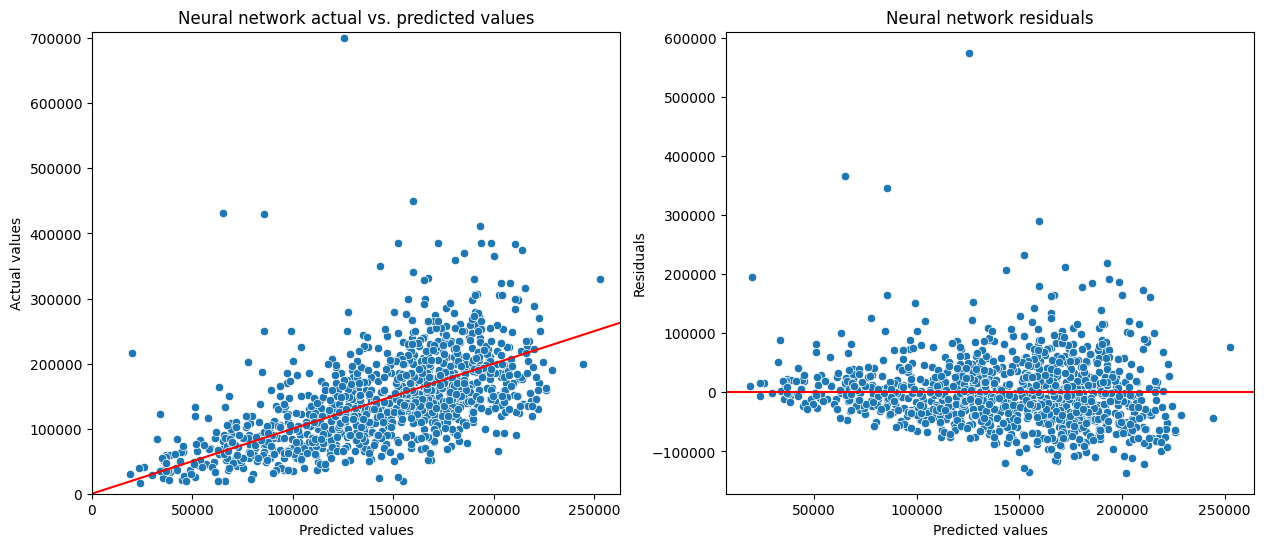

In [48]:
# initialize model, loss function, and optimizer
nn_model = NN(input_size, hidden_size_1, hidden_size_2, hidden_size_3, hidden_size_4)
mae = nn.L1Loss()
optimizer = Adam(nn_model.parameters(), lr=learning_rate)

# set seed for reproducibility
torch.manual_seed(0)

# get training and test sets for the 1st fold
train_indices, test_indices = next(kf.split(X, y))
X_train = X.iloc[train_indices]
X_test = X.iloc[test_indices]
y_train = y.iloc[train_indices]
y_test = y.iloc[test_indices]

# transform data to tensors
X_train_tensor = torch.from_numpy(X_train.values.astype(np.float32))
X_test_tensor = torch.from_numpy(X_test.values.astype(np.float32))
y_train_tensor = torch.from_numpy(y_train.values.astype(np.float32))
y_test_tensor = torch.from_numpy(y_test.values.astype(np.float32))

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# train model
for epoch in range(num_epochs):
    nn_model.train()

    for X_train_batch, y_train_batch in train_loader:
        # forward pass and calculate training loss
        y_train_pred = nn_model(X_train_batch).squeeze(1)
        train_mae = mae(y_train_pred, y_train_batch)

        # backward and optimize
        optimizer.zero_grad()
        train_mae.backward()
        optimizer.step()

        # accumulate training loss for the current batch
        total_train_mae += train_mae.item()

# make predictions
y_pred = nn_model(X_test_tensor).squeeze(1).detach().numpy()

# make subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
ax = axes.flatten()

# plot actual vs. predicted values
sns.scatterplot(x=y_pred, y=y_test, ax=ax[0])
ax[0].set_xlim(0, max(y_pred) + 10000)
ax[0].set_ylim(0, max(y_test) + 10000)
ax[0].set_xlabel("Predicted values")
ax[0].set_ylabel("Actual values")
ax[0].set_title("Neural network actual vs. predicted values")
ax[0].plot([0, max(y_test)], [0, max(y_test)], "r")

# plot residuals
residuals = y_test - y_pred
sns.scatterplot(x=y_pred, y=residuals, ax=ax[1])
ax[1].set_xlabel("Predicted values")
ax[1].set_ylabel("Residuals")
ax[1].set_title("Neural network residuals")
ax[1].axhline(y=0, color="r")

### Box-Cox Transformation

- If we look at the residual plots for the models above, the residuals are not equally scattered (heteroscedasticity).
- This violates one of the assumptions of the linear model that the residuals have constant variance (homoscedasticity).
- To counter this, we will try to see if a [Box-Cox transformation](https://www.statisticshowto.com/probability-and-statistics/normal-distributions/box-cox-transformation/) can make the target variable more normally distributed.

In [49]:
# get training and test sets for the 1st fold
train_indices, test_indices = next(kf.split(X, y))
X_train = X.iloc[train_indices]
X_test = X.iloc[test_indices]
y_train = y.iloc[train_indices]
y_test = y.iloc[test_indices]

# perform Box-Cox transformation
y_train_transformed, best_lambda = boxcox(y_train)
y_train_transformed, best_lambda

(array([ 941.00225005,  648.10493546, 1096.21394644, ..., 1389.91850115,
         352.52187197,  668.78746111]),
 0.5061737526724117)

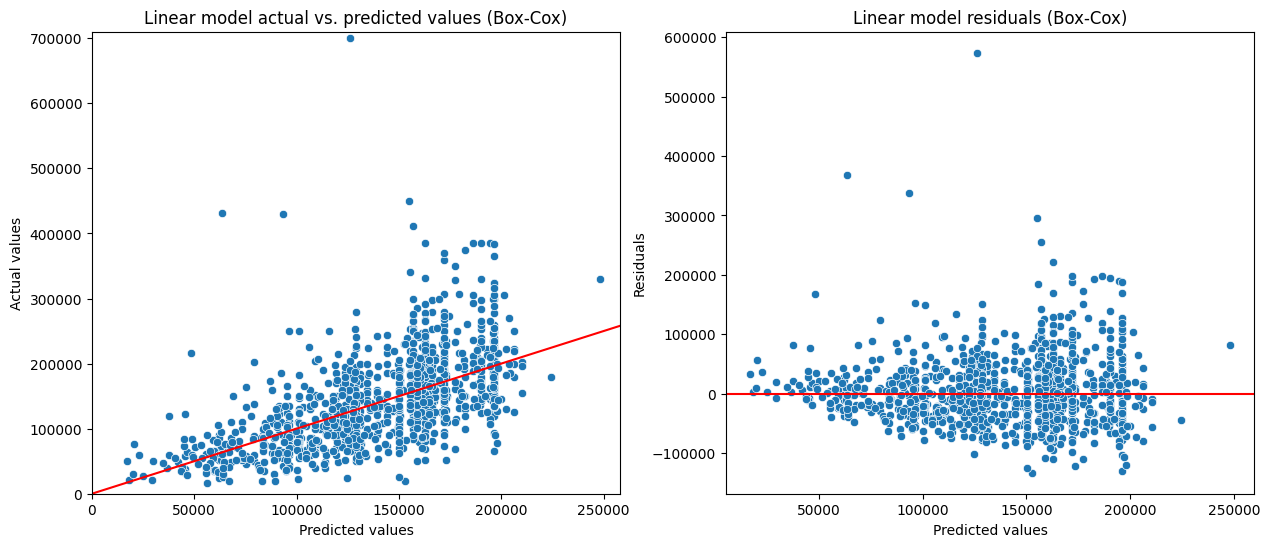

In [50]:
# fit model and make predictions
lm_model = LinearRegression()
lm_model.fit(X_train, y_train_transformed)
y_pred_transformed = lm_model.predict(X_test)
y_pred = (y_pred_transformed * best_lambda + 1) ** (1 / best_lambda) # transform back to original scale

# make subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
ax = axes.flatten()

# plot actual vs. predicted values
sns.scatterplot(x=y_pred, y=y_test, ax=ax[0])
ax[0].set_xlim(0, max(y_pred) + 10000)
ax[0].set_ylim(0, max(y_test) + 10000)
ax[0].set_xlabel("Predicted values")
ax[0].set_ylabel("Actual values")
ax[0].set_title("Linear model actual vs. predicted values (Box-Cox)")
ax[0].plot([0, max(y_test)], [0, max(y_test)], "r")

# plot residuals
residuals = y_test - y_pred
sns.scatterplot(x=y_pred, y=residuals, ax=ax[1])
ax[1].set_xlabel("Predicted values")
ax[1].set_ylabel("Residuals")
ax[1].set_title("Linear model residuals (Box-Cox)")
ax[1].axhline(y=0, color="r")

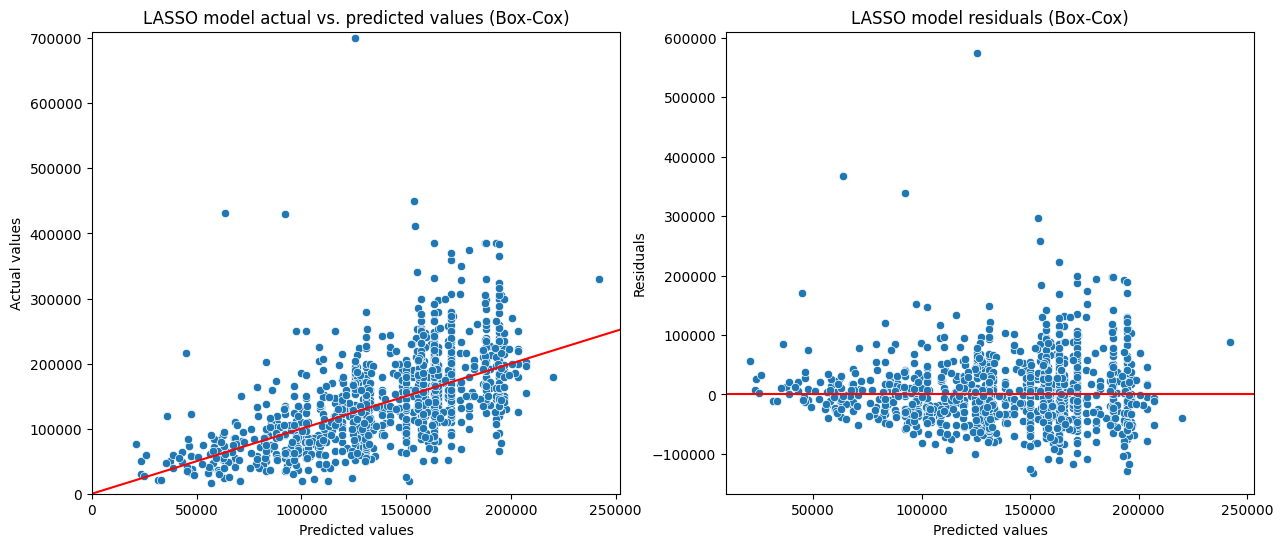

In [51]:
# fit model and make predictions
lasso_model = LassoCV(n_alphas=1000)
lasso_model.fit(X_train, y_train_transformed)
y_pred_transformed = lasso_model.predict(X_test)
y_pred = (y_pred_transformed * best_lambda + 1) ** (1 / best_lambda) # transform back to original scale

# make subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
ax = axes.flatten()

# plot actual vs. predicted values
sns.scatterplot(x=y_pred, y=y_test, ax=ax[0])
ax[0].set_xlim(0, max(y_pred) + 10000)
ax[0].set_ylim(0, max(y_test) + 10000)
ax[0].set_xlabel("Predicted values")
ax[0].set_ylabel("Actual values")
ax[0].set_title("LASSO model actual vs. predicted values (Box-Cox)")
ax[0].plot([0, max(y_test)], [0, max(y_test)], "r")

# plot residuals
residuals = y_test - y_pred
sns.scatterplot(x=y_pred, y=residuals, ax=ax[1])
ax[1].set_xlabel("Predicted values")
ax[1].set_ylabel("Residuals")
ax[1].set_title("LASSO model residuals (Box-Cox)")
ax[1].axhline(y=0, color="r")

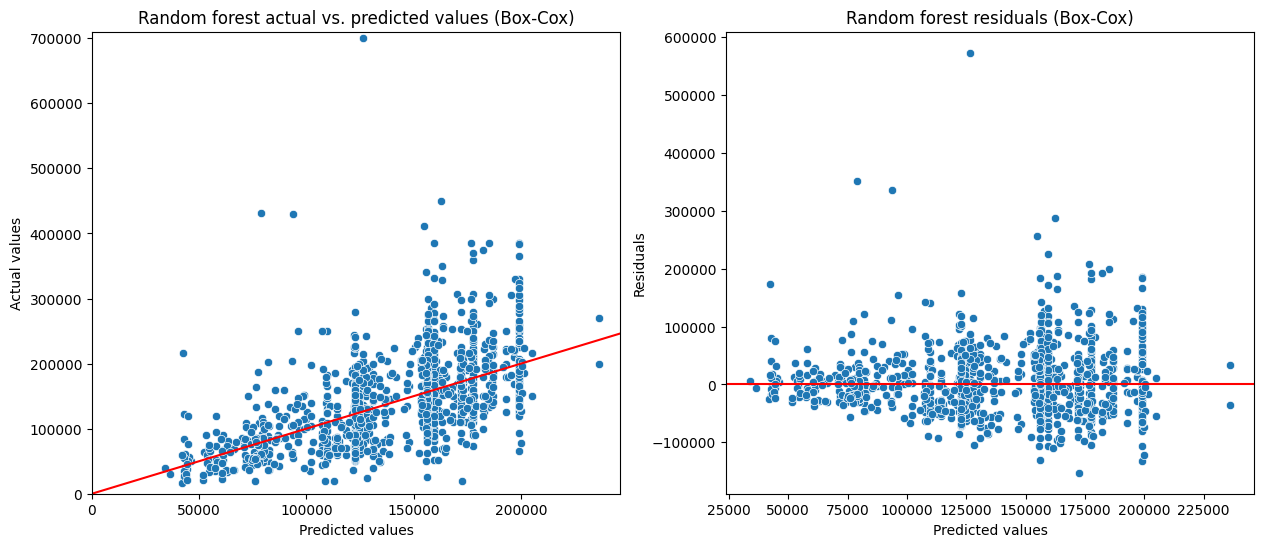

In [59]:
# fit model and make predictions
rf_model = RandomForestRegressor(**rf_best_params, random_state=1, n_jobs=4)
rf_model.fit(X_train, y_train_transformed)
y_pred_transformed = rf_model.predict(X_test)
y_pred = (y_pred_transformed * best_lambda + 1) ** (1 / best_lambda) # transform back to original scale

# make subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
ax = axes.flatten()

# plot actual vs. predicted values
sns.scatterplot(x=y_pred, y=y_test, ax=ax[0])
ax[0].set_xlim(0, max(y_pred) + 10000)
ax[0].set_ylim(0, max(y_test) + 10000)
ax[0].set_xlabel("Predicted values")
ax[0].set_ylabel("Actual values")
ax[0].set_title("Random forest actual vs. predicted values (Box-Cox)")
ax[0].plot([0, max(y_test)], [0, max(y_test)], "r")

# plot residuals
residuals = y_test - y_pred
sns.scatterplot(x=y_pred, y=residuals, ax=ax[1])
ax[1].set_xlabel("Predicted values")
ax[1].set_ylabel("Residuals")
ax[1].set_title("Random forest residuals (Box-Cox)")
ax[1].axhline(y=0, color="r")

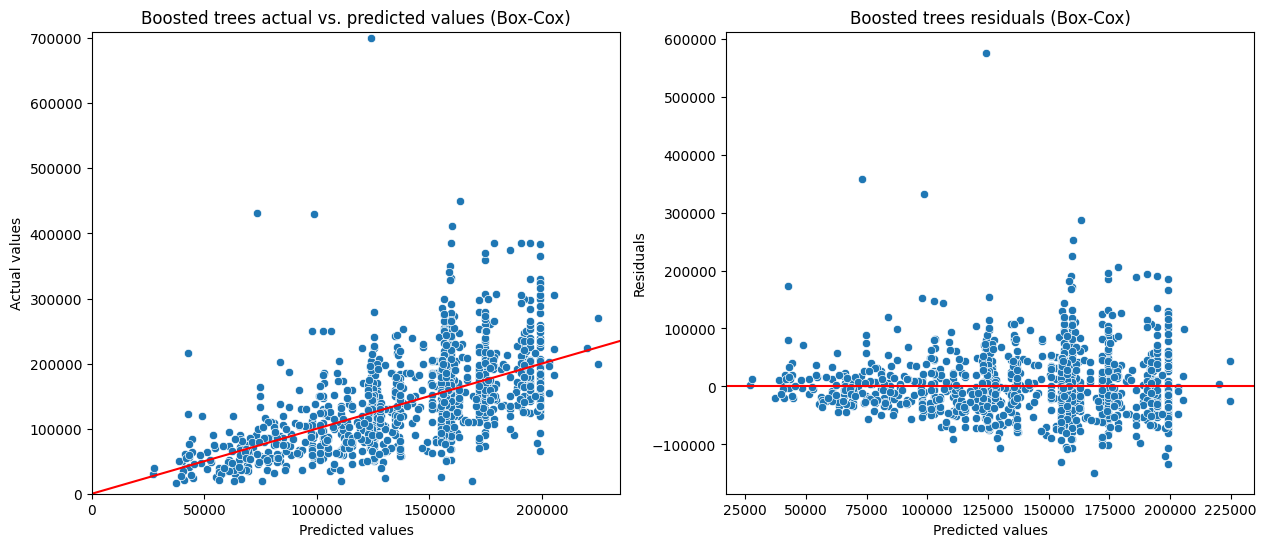

In [53]:
# fit model and make predictions
gb_model = GradientBoostingRegressor(**gb_best_params, subsample=0.8, random_state=1)
gb_model.fit(X_train, y_train_transformed)
y_pred_transformed = gb_model.predict(X_test)
y_pred = (y_pred_transformed * best_lambda + 1) ** (1 / best_lambda) # transform back to original scale

# make subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
ax = axes.flatten()

# plot actual vs. predicted values
sns.scatterplot(x=y_pred, y=y_test, ax=ax[0])
ax[0].set_xlim(0, max(y_pred) + 10000)
ax[0].set_ylim(0, max(y_test) + 10000)
ax[0].set_xlabel("Predicted values")
ax[0].set_ylabel("Actual values")
ax[0].set_title("Boosted trees actual vs. predicted values (Box-Cox)")
ax[0].plot([0, max(y_test)], [0, max(y_test)], "r")

# plot residuals
residuals = y_test - y_pred
sns.scatterplot(x=y_pred, y=residuals, ax=ax[1])
ax[1].set_xlabel("Predicted values")
ax[1].set_ylabel("Residuals")
ax[1].set_title("Boosted trees residuals (Box-Cox)")
ax[1].axhline(y=0, color="r")

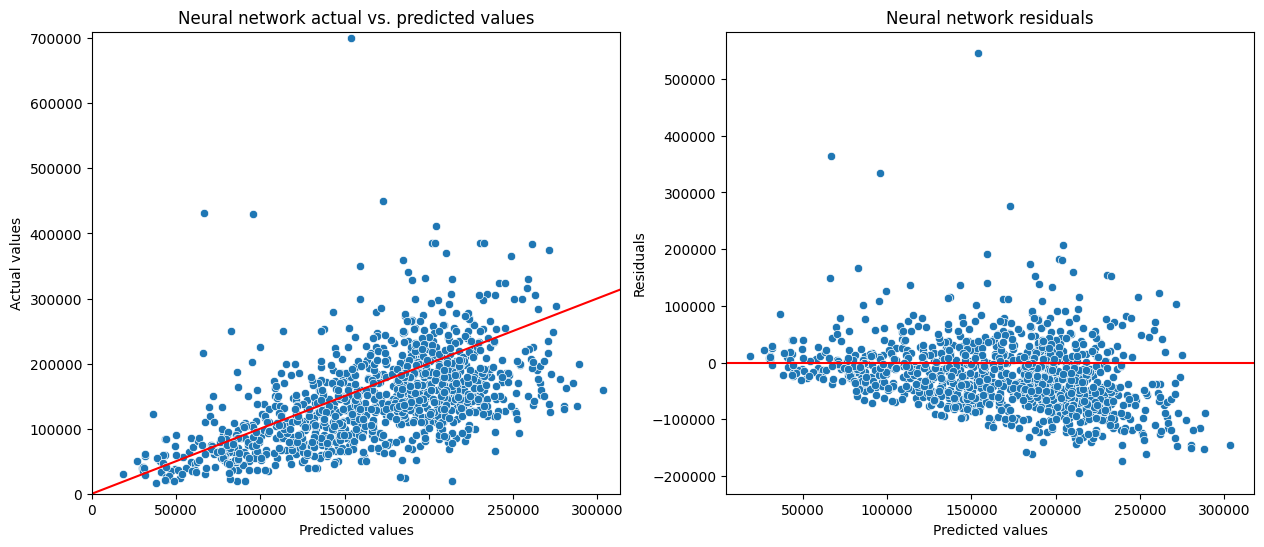

In [64]:
# initialize model, loss function, and optimizer
nn_model = NN(input_size, hidden_size_1, hidden_size_2, hidden_size_3, hidden_size_4)
mae = nn.L1Loss()
optimizer = Adam(nn_model.parameters(), lr=learning_rate)

# set seed for reproducibility
torch.manual_seed(0)

# get training and test sets for the 1st fold
train_indices, test_indices = next(kf.split(X, y))
X_train = X.iloc[train_indices]
X_test = X.iloc[test_indices]
y_train = y_train_transformed

# transform data to tensors
X_train_tensor = torch.from_numpy(X_train.values.astype(np.float32))
X_test_tensor = torch.from_numpy(X_test.values.astype(np.float32))
y_train_tensor = torch.from_numpy(y_train.astype(np.float32))

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)

# create data loader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# train model
for epoch in range(num_epochs):
    nn_model.train()

    for X_train_batch, y_train_batch in train_loader:
        # forward pass and calculate training loss
        y_train_pred = nn_model(X_train_batch).squeeze(1)
        train_mae = mae(y_train_pred, y_train_batch)

        # backward and optimize
        optimizer.zero_grad()
        train_mae.backward()
        optimizer.step()

        # accumulate training loss for the current batch
        total_train_mae += train_mae.item()

# make predictions
y_pred_transformed = nn_model(X_test_tensor).squeeze(1).detach().numpy()
y_pred = (y_pred_transformed * best_lambda + 1) ** (1 / best_lambda) # transform back to original scale

# make subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
ax = axes.flatten()

# plot actual vs. predicted values
sns.scatterplot(x=y_pred, y=y_test, ax=ax[0])
ax[0].set_xlim(0, max(y_pred) + 10000)
ax[0].set_ylim(0, max(y_test) + 10000)
ax[0].set_xlabel("Predicted values")
ax[0].set_ylabel("Actual values")
ax[0].set_title("Neural network actual vs. predicted values")
ax[0].plot([0, max(y_test)], [0, max(y_test)], "r")

# plot residuals
residuals = y_test - y_pred
sns.scatterplot(x=y_pred, y=residuals, ax=ax[1])
ax[1].set_xlabel("Predicted values")
ax[1].set_ylabel("Residuals")
ax[1].set_title("Neural network residuals")
ax[1].axhline(y=0, color="r")

- Unfortunately, the Box-Cox transformation did not resolve the issue of heteroscedasticity.
- This might be because the target variable is not normally distributed.
- We can check by plotting a histogram of the target variable and using the Shapiro-Wilk test, which tests if a set of points is normally distributed.

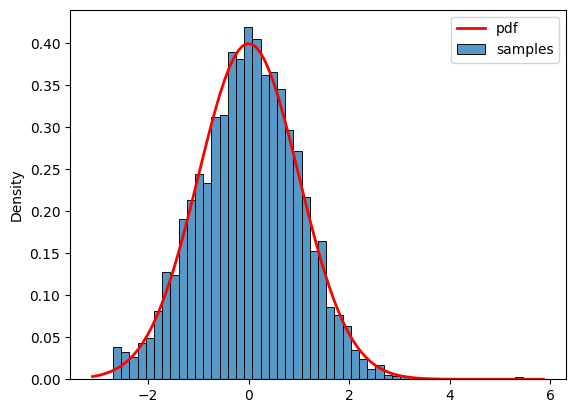

In [56]:
# standardize data
x = (y_train_transformed - y_train_transformed.mean()) / y_train_transformed.std()

# plot histogram of standardized data
ax = sns.histplot(x, kde=False, stat="density", label="samples")

# calculate the pdf of the standard normal distribution
x0, x1 = ax.get_xlim()
x_pdf = np.linspace(x0, x1, 100)
y_pdf = norm.pdf(x_pdf)

# plot standard normal distribution
ax.plot(x_pdf, y_pdf, "r", lw=2, label="pdf")
ax.legend()

In [57]:
# p-value of Shapiro-Wilk test
shapiro(x).pvalue

9.396224243118922e-08

- Despite many of the points falling within the density curve, the histogram has an irregularly long right tail, so the data is right-skewed.
- The p-value of the Shapiro-Wilk test is less than 0.05, so we reject the null hypothesis that the data comes from a normal distribution.
- Performing a Box-Cox transformation did not make the residuals more homoscedastic (constant variance).

## Results & Analysis

In [58]:
# combine results into one dataframe
cv_results = [dummy_cv_results, lm_cv_results, lasso_cv_results, rf_cv_results, gb_cv_results, nn_cv_results]
cv_results_df = pd.concat(cv_results, axis=1)
cv_results_df

,dummy_cv,linear_cv,lasso_cv,rf_cv,gb_cv,nn_cv
test_mae_avg,53813.180222,41381.359833,41377.526233,41260.309760,40949.912097,40532.352423
train_mae_avg,53793.468421,41030.051241,41054.992270,39217.376217,38735.669027,38575.737107
test_rmse_avg,68989.733389,55509.230202,55498.416245,52729.752517,52301.409345,52393.873437
train_rmse_avg,68988.669716,55031.376211,55084.467081,52729.752517,52301.409345,50927.823485


- Model comparison
  - The neural network seemed to perform the best across most of the metrics.
  - The ensemble methods performed slightly better than the linear models.
  - All models performed better than the dummy model (i.e., learned some pattern).
  - However, the metrics across models aren’t vastly different from each other, which may have to do with the underlying data we are using. 
    - We are only using categorical variables, so the models are essentially predicting salaries based on a bunch of 0s and 1s.
- Linear models (linear and LASSO regression)
  - These models assume that there is a linear relationship between each predictor and salaries.
  - The most important variables (in terms of the magnitude of the coefficient estimates) are location, experience, and job category.
- Ensemble methods (random forest and boosted trees)
  - These models allow for nonlinear relationships, including interactions between the predictors – this may be why they had lower test errors compared to the linear models.
  - The most important variables (in terms of feature importance) are also location, experience, and job category.
- Neural network
  - The neural network appears to be overfitting to the training data, which again could be due to the dataset that we used.
- Box-Cox transformation
  - The residuals exhibited heteroscedasticity, and using a Box-Cox transformation did not resolve this issue.
  - This might be because the data has a few observations where the salaries are on the higher end, so it doesn't follow a normal distribution.

## Conclusion

### Main Findings

- Model performance
  - Neural network performed the best, but it may not be the most optimal model since it does not appear to generalize well to new data.
  - For interpretability, boosted trees might be a better model since the model includes feature importance.
- Based on the models we ran, company location, experience, and job category affect salary predictions the most. Higher salaries tended to have the following features:
  - Countries with higher GDP (e.g., US, Canada)
  - More time in the industry (senior- / executive-level)
  - More specialized knowledge (e.g., data management, data scientist)

### Limitations

- Dataset
  - There is a substantial range of salaries in combination with a lack of data entries (only a few thousand observations). 
  - The data lacks features that might have higher correlation with salaries, such as gender, education level, etc.
  - There is also a lack of work year diversity since we only have data from 2020-2023.
  - There is an imbalance of data in several categories – for example, there are not enough data entries for part time-jobs and freelance in comparison to full-time jobs.
- Others
  - The groupings of `job_category` and `job_field` might be insufficient due to the lack of industry standardized nomenclature for data science jobs.
  - The heteroscedasticity of the residuals could undermine our results, especially for linear models that rely on the assumption of homoscedasticity.

### Future Analysis

- Geographic salary trends
  - Explore salary variations across different geographic regions, countries, or cities.
  - Identify areas with the highest demand for data scientists and the corresponding salary levels.
- Skill-based analysis
  - Investigate the correlation between specific technical skills (e.g., machine learning, big data, programming languages) and salary levels.
  - Explore the impact of acquiring certifications or advanced degrees on salary.
- Experience and career progression
  - Study how salaries change with different experience levels in the field of data science.
  - Analyze the career progression and salary growth for data scientists over time.
- Gender and diversity pay gap
  - Explore gender and diversity pay gaps within the data science field.
  - Identify areas for improvement in terms of salary equality.